In [547]:
import requests
import time
import calendar
from math import floor
from collections import defaultdict, Counter
from datetime import datetime
from bisect import bisect_right

import numpy as np
import matplotlib.pyplot as plt

In [316]:
PRIMARY_RED = "#7A1616"
ACCENT_RED = "#BA0606"
GRID_GRAY = "#E6E6E6"
TEXT_DARK = "#2B2B2B"

def red_shades(n):
    cmap = plt.cm.Reds
    return [cmap(v) for v in np.linspace(0.45, 0.9, n)]

In [510]:
BINS = [
    (1, 2),
    (3, 5),
    (6, 10),
    (11, 20),
    (21, 50),
    (51, 100),
    (101, 200),
    (201, 1000),
]


In [568]:
STATS_YEARS = (2023, 2024, 2025)

In [23]:
raw_url = 'https://api.statsim.net/api/Flights/Icao?icao={}&from={}T{}Z&to={}T{}Z'

In [394]:
aerodromes = ['EPWA', 'EPMO', 'EPGD', 'EPKK', 'EPKT', 'EPPO', 'EPWR', 'EPLL', 'EPRA', 'EPBY', 'EPRZ', 'EPZG', 'EPSY', 'EPLB', 'EPSC']
aerodromes_comparative_basket = ['EDDM', 'EDDL', 'LKPR', 'EFHK', 'LOWW', 'ENBR', 'EETN']

In [452]:
def resolve_icaos(icao, aerodromes):
    if icao == "EPWW":
        return aerodromes
    return [icao]

In [106]:
weekday_names = {0: 'poniedziałek', 1: 'wtorek', 2: 'środa', 3: 'czwartek', 4: 'piątek', 5: 'sobota', 6: 'niedziela'}

In [311]:
def get_last_day_of_month(month: int, year: int):
    test_date = datetime(year, month, 1)
    return calendar.monthrange(test_date.year, test_date.month)[1]    

In [92]:
def floored_percentage(val, digits):
    val *= 10 ** (digits + 2)
    return '{1:.{0}f}%'.format(digits, floor(val) / 10 ** digits)

In [308]:
# Ściąga dane dla danego miesiąca dla danego AD

def get_operations_month(icao: str, month: int, year: int):
    date_from = f'{year}-{month}-01'
    date_to = f'{year}-{month}-{get_last_day_of_month(month, year)}'
    hour_from = '00:00:00.000'
    hour_to = '23:59:59.999'
    url = raw_url.format(icao, date_from, hour_from, date_to, hour_to)
    raw_ops = requests.get(url)
    print(raw_ops, url)
    to_json = raw_ops.json()
    return to_json

In [307]:
# Ściąga dane dla całego roku dla danego AD

def get_operations_year(icao: str, year: int, timeout: float = 2.25):
    all_ops = []
    for month in range(1, 12+1):
        print(f'Fetching ops from and to {icao} for {month}-{year}...')
        month_ops = get_operations_month(icao, month, year)
        all_ops.extend(month_ops)
        print(f'Done. Sleep for {timeout} seconds.')
        time.sleep(timeout)
    return all_ops

In [305]:
# Ściąga dane dla całego roku dla wszystkich AD

def fetch_stats_for_a_year(year: int, stats_by_year: dict, aerodromes: dict, timeout: float = 4.00):
    stats_by_year[year] = {icao: [] for icao in aerodromes}
    for icao in aerodromes:
        stats_by_year[year][icao].extend(get_operations_year(icao, year, timeout))

In [304]:
# Operacje rozbite na AD zwraca jako jedną listę dla całego vFIR

def get_all_ops_vfir(year: int, stats_by_year: dict):
    ops = []
    for icao, ad_ops in stats_by_year[year].items():
        ops.extend(ad_ops)
    return ops

In [303]:
# Oblicza dla całego vFIR w danym roku: operacje, unikalne loty, unikalnych pilotów

def count_flights_vfir(year: int, stats_by_year: dict):
    op_count = 0
    unique_flights = set()
    unique_pilots = set()
    for icao, ops in stats_by_year[year].items():
        for op in ops:
            unique_flights.add(op['id'])
            unique_pilots.add(op['vatsimid'])
            op_count += 1
    return op_count, len(unique_flights), len(unique_pilots)           

In [302]:
# Oblicza operacje w poszczególne dni tygodnia

def count_ops_by_weekdays(ops: list, icao: str):
    weekday_flights = {k: {'departures': 0, 'arrivals': 0} for k in range(7)}
    for op in ops:
        try:
            if op['departure'] == icao:
                date = datetime.fromisoformat(op['departed'])
                weekday_flights[date.weekday()]['departures'] += 1
            elif op['destination'] == icao:
                date = datetime.fromisoformat(op['arrived'])
                weekday_flights[date.weekday()]['arrivals'] += 1
        except:
            print('Error with', op)
    return weekday_flights

In [301]:
# Oblicza, ile było operacji w poszczególne dni roku

def count_ops_for_each_day(icao: str, year: int, stats_by_year: dict):
    ops_year = stats_by_year[year][icao]
    day_ops = defaultdict(int)
    for op in ops_year:
        try:
            if op['departure'] == icao:
                date = datetime.fromisoformat(op['departed'])
            elif op['destination'] == icao:
                date = datetime.fromisoformat(op['arrived'])
            day_of_year = date.timetuple().tm_yday
            day_ops[day_of_year] += 1
        except:
            print('Error with', op)
    return day_ops
        

In [115]:
stats_by_year = {}

In [169]:
fetch_stats_for_a_year(2023, stats_by_year, aerodromes, timeout=3.25)

Fetching ops from and to EPWA for 1-2023...
<Response [200]> https://api.statsim.net/api/Flights/Icao?icao=EPWA&from=2023-1-01T00:00:00.000Z&to=2023-1-31T23:59:59.999Z
Done. Sleep for 3.25 seconds.
Fetching ops from and to EPWA for 2-2023...
<Response [200]> https://api.statsim.net/api/Flights/Icao?icao=EPWA&from=2023-2-01T00:00:00.000Z&to=2023-2-28T23:59:59.999Z
Done. Sleep for 3.25 seconds.
Fetching ops from and to EPWA for 3-2023...
<Response [200]> https://api.statsim.net/api/Flights/Icao?icao=EPWA&from=2023-3-01T00:00:00.000Z&to=2023-3-31T23:59:59.999Z
Done. Sleep for 3.25 seconds.
Fetching ops from and to EPWA for 4-2023...
<Response [200]> https://api.statsim.net/api/Flights/Icao?icao=EPWA&from=2023-4-01T00:00:00.000Z&to=2023-4-30T23:59:59.999Z
Done. Sleep for 3.25 seconds.
Fetching ops from and to EPWA for 5-2023...
<Response [200]> https://api.statsim.net/api/Flights/Icao?icao=EPWA&from=2023-5-01T00:00:00.000Z&to=2023-5-31T23:59:59.999Z
Done. Sleep for 3.25 seconds.
Fetching o

In [168]:
fetch_stats_for_a_year(2024, stats_by_year, aerodromes, timeout=2.75)

Fetching ops from and to EPWA for 1-2024...
<Response [200]> https://api.statsim.net/api/Flights/Icao?icao=EPWA&from=2024-1-01T00:00:00.000Z&to=2024-1-31T23:59:59.999Z
Done. Sleep for 2.75 seconds.
Fetching ops from and to EPWA for 2-2024...
<Response [200]> https://api.statsim.net/api/Flights/Icao?icao=EPWA&from=2024-2-01T00:00:00.000Z&to=2024-2-29T23:59:59.999Z
Done. Sleep for 2.75 seconds.
Fetching ops from and to EPWA for 3-2024...
<Response [200]> https://api.statsim.net/api/Flights/Icao?icao=EPWA&from=2024-3-01T00:00:00.000Z&to=2024-3-31T23:59:59.999Z
Done. Sleep for 2.75 seconds.
Fetching ops from and to EPWA for 4-2024...
<Response [200]> https://api.statsim.net/api/Flights/Icao?icao=EPWA&from=2024-4-01T00:00:00.000Z&to=2024-4-30T23:59:59.999Z
Done. Sleep for 2.75 seconds.
Fetching ops from and to EPWA for 5-2024...
<Response [200]> https://api.statsim.net/api/Flights/Icao?icao=EPWA&from=2024-5-01T00:00:00.000Z&to=2024-5-31T23:59:59.999Z
Done. Sleep for 2.75 seconds.
Fetching o

In [584]:
# do 31.12.2025 o ~23:50LT

fetch_stats_for_a_year(2025, stats_by_year, aerodromes, timeout=3.05)

Fetching ops from and to EPWA for 1-2025...
<Response [200]> https://api.statsim.net/api/Flights/Icao?icao=EPWA&from=2025-1-01T00:00:00.000Z&to=2025-1-31T23:59:59.999Z
Done. Sleep for 3.05 seconds.
Fetching ops from and to EPWA for 2-2025...
<Response [200]> https://api.statsim.net/api/Flights/Icao?icao=EPWA&from=2025-2-01T00:00:00.000Z&to=2025-2-28T23:59:59.999Z
Done. Sleep for 3.05 seconds.
Fetching ops from and to EPWA for 3-2025...
<Response [200]> https://api.statsim.net/api/Flights/Icao?icao=EPWA&from=2025-3-01T00:00:00.000Z&to=2025-3-31T23:59:59.999Z
Done. Sleep for 3.05 seconds.
Fetching ops from and to EPWA for 4-2025...
<Response [200]> https://api.statsim.net/api/Flights/Icao?icao=EPWA&from=2025-4-01T00:00:00.000Z&to=2025-4-30T23:59:59.999Z
Done. Sleep for 3.05 seconds.
Fetching ops from and to EPWA for 5-2025...
<Response [200]> https://api.statsim.net/api/Flights/Icao?icao=EPWA&from=2025-5-01T00:00:00.000Z&to=2025-5-31T23:59:59.999Z
Done. Sleep for 3.05 seconds.
Fetching o

In [395]:
# Dane porównawcze dla EDDM, EDDL, LKPR, EFHK, LOWW, ENBR, EETN

comparative_stats_by_year = {}

In [396]:
fetch_stats_for_a_year(2023, comparative_stats_by_year, aerodromes_comparative_basket, timeout=3.1)

Fetching ops from and to EDDM for 1-2023...
<Response [200]> https://api.statsim.net/api/Flights/Icao?icao=EDDM&from=2023-1-01T00:00:00.000Z&to=2023-1-31T23:59:59.999Z
Done. Sleep for 3.1 seconds.
Fetching ops from and to EDDM for 2-2023...
<Response [200]> https://api.statsim.net/api/Flights/Icao?icao=EDDM&from=2023-2-01T00:00:00.000Z&to=2023-2-28T23:59:59.999Z
Done. Sleep for 3.1 seconds.
Fetching ops from and to EDDM for 3-2023...
<Response [200]> https://api.statsim.net/api/Flights/Icao?icao=EDDM&from=2023-3-01T00:00:00.000Z&to=2023-3-31T23:59:59.999Z
Done. Sleep for 3.1 seconds.
Fetching ops from and to EDDM for 4-2023...
<Response [200]> https://api.statsim.net/api/Flights/Icao?icao=EDDM&from=2023-4-01T00:00:00.000Z&to=2023-4-30T23:59:59.999Z
Done. Sleep for 3.1 seconds.
Fetching ops from and to EDDM for 5-2023...
<Response [200]> https://api.statsim.net/api/Flights/Icao?icao=EDDM&from=2023-5-01T00:00:00.000Z&to=2023-5-31T23:59:59.999Z
Done. Sleep for 3.1 seconds.
Fetching ops fr

In [402]:
fetch_stats_for_a_year(2024, comparative_stats_by_year, aerodromes_comparative_basket, timeout=3.1)

Fetching ops from and to EDDM for 1-2024...
<Response [200]> https://api.statsim.net/api/Flights/Icao?icao=EDDM&from=2024-1-01T00:00:00.000Z&to=2024-1-31T23:59:59.999Z
Done. Sleep for 3.1 seconds.
Fetching ops from and to EDDM for 2-2024...
<Response [200]> https://api.statsim.net/api/Flights/Icao?icao=EDDM&from=2024-2-01T00:00:00.000Z&to=2024-2-29T23:59:59.999Z
Done. Sleep for 3.1 seconds.
Fetching ops from and to EDDM for 3-2024...
<Response [200]> https://api.statsim.net/api/Flights/Icao?icao=EDDM&from=2024-3-01T00:00:00.000Z&to=2024-3-31T23:59:59.999Z
Done. Sleep for 3.1 seconds.
Fetching ops from and to EDDM for 4-2024...
<Response [200]> https://api.statsim.net/api/Flights/Icao?icao=EDDM&from=2024-4-01T00:00:00.000Z&to=2024-4-30T23:59:59.999Z
Done. Sleep for 3.1 seconds.
Fetching ops from and to EDDM for 5-2024...
<Response [200]> https://api.statsim.net/api/Flights/Icao?icao=EDDM&from=2024-5-01T00:00:00.000Z&to=2024-5-31T23:59:59.999Z
Done. Sleep for 3.1 seconds.
Fetching ops fr

In [586]:
fetch_stats_for_a_year(2025, comparative_stats_by_year, aerodromes_comparative_basket, timeout=3)

Fetching ops from and to EDDM for 1-2025...
<Response [200]> https://api.statsim.net/api/Flights/Icao?icao=EDDM&from=2025-1-01T00:00:00.000Z&to=2025-1-31T23:59:59.999Z
Done. Sleep for 3 seconds.
Fetching ops from and to EDDM for 2-2025...
<Response [200]> https://api.statsim.net/api/Flights/Icao?icao=EDDM&from=2025-2-01T00:00:00.000Z&to=2025-2-28T23:59:59.999Z
Done. Sleep for 3 seconds.
Fetching ops from and to EDDM for 3-2025...
<Response [200]> https://api.statsim.net/api/Flights/Icao?icao=EDDM&from=2025-3-01T00:00:00.000Z&to=2025-3-31T23:59:59.999Z
Done. Sleep for 3 seconds.
Fetching ops from and to EDDM for 4-2025...
<Response [200]> https://api.statsim.net/api/Flights/Icao?icao=EDDM&from=2025-4-01T00:00:00.000Z&to=2025-4-30T23:59:59.999Z
Done. Sleep for 3 seconds.
Fetching ops from and to EDDM for 5-2025...
<Response [200]> https://api.statsim.net/api/Flights/Icao?icao=EDDM&from=2025-5-01T00:00:00.000Z&to=2025-5-31T23:59:59.999Z
Done. Sleep for 3 seconds.
Fetching ops from and to 

In [388]:
events_2024 = [
    {
        "aerodromes": ["EPWR", "EPPO"],
        "date": "2024-02-08",
        "hour_start": "18:00:00.000Z",
        "hour_end": "21:00:00.000Z",
    },
    {
        "aerodromes": ["EPKT", "EPKK"],
        "date": "2024-01-27",
        "hour_start": "19:00:00.000Z",
        "hour_end": "21:30:00.000Z",
    },
    {
        "aerodromes": ["EPWA"],
        "date": "2024-02-17",
        "hour_start": "17:30:00.000Z",
        "hour_end": "20:00:00.000Z",
    },
    {
        "aerodromes": ["EPWA"],
        "date": "2024-02-25",
        "hour_start": "15:00:00.000Z",
        "hour_end": "18:00:00.000Z",
    },
    {
        "aerodromes": ["EPGD"],
        "date": "2024-03-08",
        "hour_start": "17:00:00.000Z",
        "hour_end": "21:00:00.000Z",
    },
    {
        "aerodromes": ["EPWA"],
        "date": "2024-03-24",
        "hour_start": "18:00:00.000Z",
        "hour_end": "22:00:00.000Z",
    },
    {
        "aerodromes": ["EPMO"],
        "date": "2024-04-01",
        "hour_start": "16:00:00.000Z",
        "hour_end": "20:00:00.000Z",
    },
    {
        "aerodromes": ["EPGD"],
        "date": "2024-05-10",
        "hour_start": "17:00:00.000Z",
        "hour_end": "20:00:00.000Z",
    },
    {
        "aerodromes": ["EPWA"],
        "date": "2024-06-02",
        "hour_start": "15:00:00.000Z",
        "hour_end": "18:00:00.000Z",
    },
    {
        "aerodromes": ["EPWA"],
        "date": "2024-06-16",
        "hour_start": "17:00:00.000Z",
        "hour_end": "20:00:00.000Z",
    },
    {
        "aerodromes": ["EPWA", "EPGD", "EPKK", "EPKT"],
        "date": "2024-06-22",
        "hour_start": "11:00:00.000Z",
        "hour_end": "15:00:00.000Z",
    },
    {
        "aerodromes": ["EPWA", "EPPO", "EPKT", "EPGD"],
        "date": "2024-07-13",
        "hour_start": "09:00:00.000Z",
        "hour_end": "12:00:00.000Z",
    },
    {
        "aerodromes": ["EPWA"],
        "date": "2024-08-10",
        "hour_start": "06:00:00.000Z",
        "hour_end": "10:00:00.000Z",
    },
    {
        "aerodromes": ["EPKK"],
        "date": "2024-09-01",
        "hour_start": "14:00:00.000Z",
        "hour_end": "17:00:00.000Z",
    },
    {
        "aerodromes": ["EPWA", "EPGD", "EPKK", "EPKT"],
        "date": "2024-09-28",
        "hour_start": "12:00:00.000Z",
        "hour_end": "16:00:00.000Z",
    },
    {
        "aerodromes": ["EPWA"],
        "date": "2024-10-20",
        "hour_start": "16:00:00.000Z",
        "hour_end": "20:00:00.000Z",
    },
    {
        "aerodromes": [
            "EPWA",
            "EPMO",
            "EPGD",
            "EPKK",
            "EPKT",
            "EPPO",
            "EPWR",
            "EPLL",
            "EPRA",
            "EPBY",
            "EPRZ",
            "EPZG",
            "EPSY",
            "EPLB",
            "EPSC",
        ],
        "date": "2024-11-09",
        "hour_start": "09:00:00.000Z",
        "hour_end": "21:00:00.000Z",
    },
    {
        "aerodromes": ["EPWA"],
        "date": "2024-12-18",
        "hour_start": "18:00:00.000Z",
        "hour_end": "21:00:00.000Z",
    },
    {
        "aerodromes": ["EPWA", "EPGD", "EPKK"],
        "date": "2024-12-29",
        "hour_start": "18:00:00.000Z",
        "hour_end": "21:00:00.000Z",
    },
]

In [479]:
events_2025 = [
    {
        "aerodromes": ["EPWA"],
        "date": "2025-01-05",
        "hour_start": "17:00:00.000Z",
        "hour_end": "20:00:00.000Z",
    },
    {
        "aerodromes": ["EPKK", "EPGD", "EPWA"],
        "date": "2025-01-26",
        "hour_start": "12:00:00.000Z",
        "hour_end": "18:30:00.000Z",
    },
    {
        "aerodromes": ["EPKK"],
        "date": "2025-02-08",
        "hour_start": "08:00:00.000Z",
        "hour_end": "23:00:00.000Z",
    },
    {
        "aerodromes": ["EPWA"],
        "date": "2025-03-01",
        "hour_start": "17:00:00.000Z",
        "hour_end": "20:00:00.000Z",
    },
    {
        "aerodromes": ["EPLL", "EPRA", "EPMO", "EPWA"],
        "date": "2025-03-02",
        "hour_start": "18:00:00.000Z",
        "hour_end": "21:00:00.000Z",
    },
    {
        "aerodromes": ["EPBY", "EPGD"],
        "date": "2025-03-09",
        "hour_start": "18:00:00.000Z",
        "hour_end": "21:00:00.000Z",
    },
    {
        "aerodromes": ["EPKT", "EPKK"],
        "date": "2025-03-16",
        "hour_start": "18:00:00.000Z",
        "hour_end": "21:00:00.000Z",
    },
    {
        "aerodromes": ["EPPO", "EPWR"],
        "date": "2025-03-23",
        "hour_start": "18:00:00.000Z",
        "hour_end": "21:00:00.000Z",
    },
    {
        "aerodromes": ["EPRA", "EPLL", "EPMO", "EPWA"],
        "date": "2025-04-06",
        "hour_start": "17:00:00.000Z",
        "hour_end": "20:00:00.000Z",
    },
    {
        "aerodromes": ["EPBY", "EPGD"],
        "date": "2025-04-13",
        "hour_start": "17:00:00.000Z",
        "hour_end": "20:00:00.000Z",
    },
    {
        "aerodromes": ["EPKT", "EPKK"],
        "date": "2025-04-20",
        "hour_start": "17:00:00.000Z",
        "hour_end": "20:00:00.000Z",
    },
    {
        "aerodromes": ["EPZG", "EPWR", "EPPO"],
        "date": "2025-04-27",
        "hour_start": "17:00:00.000Z",
        "hour_end": "20:00:00.000Z",
    },
    {
        "aerodromes": ["EPRA", "EPLL", "EPMO", "EPWA"],
        "date": "2025-05-04",
        "hour_start": "17:00:00.000Z",
        "hour_end": "20:00:00.000Z",
    },
    {
        "aerodromes": ["EPBY", "EPGD"],
        "date": "2025-05-11",
        "hour_start": "17:00:00.000Z",
        "hour_end": "20:00:00.000Z",
    },
    {
        "aerodromes": ["EPKT", "EPKK"],
        "date": "2025-05-18",
        "hour_start": "17:00:00.000Z",
        "hour_end": "20:00:00.000Z",
    },
    {
        "aerodromes": ["EPZG", "EPWR", "EPPO"],
        "date": "2025-05-25",
        "hour_start": "17:00:00.000Z",
        "hour_end": "20:00:00.000Z",
    },
    {
        "aerodromes": ["EPLL", "EPRA", "EPMO", "EPWA"],
        "date": "2025-06-01",
        "hour_start": "17:00:00.000Z",
        "hour_end": "20:00:00.000Z",
    },
    {
        "aerodromes": ["EPBY", "EPGD"],
        "date": "2025-06-08",
        "hour_start": "17:00:00.000Z",
        "hour_end": "20:00:00.000Z",
    },
    {
        "aerodromes": ["EPWA"],
        "date": "2025-06-14",
        "hour_start": "03:30:00.000Z",
        "hour_end": "21:30:00.000Z",
    },
    {
        "aerodromes": ["EPKT", "EPKK"],
        "date": "2025-06-15",
        "hour_start": "17:00:00.000Z",
        "hour_end": "20:00:00.000Z",
    },
    {
        "aerodromes": ["EPZG", "EPWR", "EPPO"],
        "date": "2025-06-22",
        "hour_start": "17:00:00.000Z",
        "hour_end": "20:00:00.000Z",
    },
    {
        "aerodromes": ["EPKT", "EPWA"],
        "date": "2025-06-29",
        "hour_start": "16:00:00.000Z",
        "hour_end": "20:00:00.000Z",
    },
    {
        "aerodromes": ["EPRA", "EPLL", "EPMO", "EPWA"],
        "date": "2025-09-07",
        "hour_start": "17:00:00.000Z",
        "hour_end": "20:00:00.000Z",
    },
    {
        "aerodromes": ["EPBY", "EPGD"],
        "date": "2025-09-14",
        "hour_start": "17:00:00.000Z",
        "hour_end": "20:00:00.000Z",
    },
    {
        "aerodromes": ["EPKT", "EPKK"],
        "date": "2025-09-21",
        "hour_start": "17:00:00.000Z",
        "hour_end": "20:00:00.000Z",
    },
    {
        "aerodromes": ["EPZG", "EPWR", "EPPO"],
        "date": "2025-09-28",
        "hour_start": "17:00:00.000Z",
        "hour_end": "20:00:00.000Z",
    },
    {
        "aerodromes": ["EPRA", "EPLL", "EPMO", "EPWA"],
        "date": "2025-10-05",
        "hour_start": "20:00:00.000Z",
        "hour_end": "21:00:00.000Z",
    },
    {
        "aerodromes": ["EPBY", "EPGD"],
        "date": "2025-10-12",
        "hour_start": "17:00:00.000Z",
        "hour_end": "20:00:00.000Z",
    },
    {
        "aerodromes": ["EPKT", "EPKK"],
        "date": "2025-10-19",
        "hour_start": "17:00:00.000Z",
        "hour_end": "20:00:00.000Z",
    },
    {
        "aerodromes": ["EPZG", "EPPO"],
        "date": "2025-10-26",
        "hour_start": "18:00:00.000Z",
        "hour_end": "21:00:00.000Z",
    },
    {
        "aerodromes": ["EPRA", "EPLL", "EPMO", "EPWA"],
        "date": "2025-11-02",
        "hour_start": "18:00:00.000Z",
        "hour_end": "21:00:00.000Z",
    },
    {
        "aerodromes": aerodromes,
        "date": "2025-11-08",
        "hour_start": "10:00:00.000Z",
        "hour_end": "21:00:00.000Z",
    },
    {
        "aerodromes": ["EPBY", "EPGD"],
        "date": "2025-11-09",
        "hour_start": "18:00:00.000Z",
        "hour_end": "21:00:00.000Z",
    },
    {
        "aerodromes": ["EPRZ", "EPKT", "EPKK"],
        "date": "2025-11-16",
        "hour_start": "18:00:00.000Z",
        "hour_end": "21:00:00.000Z",
    },
    {
        "aerodromes": ["EPZG", "EPWR", "EPPO"],
        "date": "2025-11-23",
        "hour_start": "18:00:00.000Z",
        "hour_end": "21:00:00.000Z",
    },
    {
        "aerodromes": ["EPWA"],
        "date": "2025-11-30",
        "hour_start": "07:00:00.000Z",
        "hour_end": "11:00:00.000Z",
    },
    {
        "aerodromes": ["EPRA", "EPLL", "EPMO", "EPWA"],
        "date": "2025-12-07",
        "hour_start": "18:00:00.000Z",
        "hour_end": "21:00:00.000Z",
    },
    {
        "aerodromes": ["EPBY", "EPGD"],
        "date": "2025-12-14",
        "hour_start": "18:00:00.000Z",
        "hour_end": "21:00:00.000Z",
    },
    {
        "aerodromes": ["EPWA"],
        "date": "2025-12-17",
        "hour_start": "18:00:00.000Z",
        "hour_end": "21:00:00.000Z",
    },
    {
        "aerodromes": ["EPRZ", "EPKT", "EPKK"],
        "date": "2025-12-21",
        "hour_start": "18:00:00.000Z",
        "hour_end": "21:00:00.000Z",
    },
    {
        "aerodromes": ["EPZG", "EPWR", "EPPO"],
        "date": "2025-12-28",
        "hour_start": "18:00:00.000Z",
        "hour_end": "21:00:00.000Z",
    },
]

In [550]:
def preprocess_event_windows(events):
    index = defaultdict(lambda: {"starts": [], "ends": []})

    for ev in events:
        date = ev["date"]
        start = datetime.fromisoformat(f"{date}T{ev['hour_start']}")
        end   = datetime.fromisoformat(f"{date}T{ev['hour_end']}")

        for ad in ev["aerodromes"]:
            index[ad]["starts"].append(start)
            index[ad]["ends"].append(end)

    for ad in index:
        starts = index[ad]["starts"]
        ends = index[ad]["ends"]
        starts.sort()
        ends.sort()

    return index

event_index_2024 = preprocess_event_windows(events_2024)
event_index_2025 = preprocess_event_windows(events_2025)

In [551]:
# Na tym etapie mamy już dane:
# - o operacjach w vFIR EPWW (stats_by_year, schemat stats_by_year[year][icao] zwraca listę operacji na danym AD w danym roku)
# - o operacjach w "koszyku porównawczym" (comparative_stats_by_year, schemat jak wyżej)
# - o eventach w vFIR EPWW (events_2024, events_2025)

In [295]:
# Wyświetla top N najczęściej używanych tras w odlotach

def get_top_routes(stats_by_year, icao: str, year: int, top_n: int = 5):
    routes = defaultdict(int)
    for op in stats_by_year[year][icao]:
        if op['departure'] == icao:
            normalized_route = f'{op['departure']}-{op['destination']} via {op['route']}'
            routes[normalized_route] += 1
    
    c = Counter(routes)
    return c.most_common(top_n)

In [539]:
# Suma operacji na danym lotnisku kontrolowanym w danym roku

def total_ops_per_ad_per_year(stats_by_year, years, aerodromes):
        matrix = []
    
        for icao in aerodromes:
            row = []
            for year in years:
                ops = stats_by_year.get(year, {}).get(icao, [])
                row.append(len(ops))
            matrix.append(row)
    
        return matrix

In [538]:
# Średnia dzienna liczba operacji na lotniskach kontrolowanych

def get_avg_ops(year, stats_by_year, aerodromes):
    avg_ops = {}  # avg_ops[icao] = avg
    
    ops, flights, pilots = count_flights_vfir(year, stats_by_year)
    print(f'W {year} na lotniskach kontrolowanych: {ops} operacji ({flights} unikalnych lotów) wykonanych przez {pilots} pilotów.')
    print('Średnia liczba operacji dziennie:')

    for icao in aerodromes:
        counter = count_ops_for_each_day(icao, year, stats_by_year)
        avg = sum(counter.values()) / len(counter)
        avg_ops[icao] = avg
        print(f'    -> {icao}: {avg:.2f}')

    print(50 * '-')
    return avg_ops

def plot_avg_ops_by_aerodrome(avg_ops, aerodromes):
    years = sorted(avg_ops.keys())
    n_years = len(years)

    x = np.arange(len(aerodromes))
    width = 0.8 / n_years  # auto-fit bars
    colors = red_shades(n_years)

    fig, ax = plt.subplots(figsize=(14, 5))

    for i, (year, color) in enumerate(zip(years, colors)):
        values = [avg_ops[year][icao] for icao in aerodromes]
        offset = (i - (n_years - 1) / 2) * width

        bars = ax.bar(
            x + offset,
            values,
            width=width,
            label=str(year),
            color=color,
            edgecolor="#5A0F0F",
            linewidth=0.6
        )

        # Value labels
        for bar, val in zip(bars, values):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f"{val:.1f}",
                ha="center",
                va="bottom",
                fontsize=8,
                color=TEXT_DARK
            )

    ax.set_xticks(x)
    ax.set_xticklabels(aerodromes)
    ax.set_ylabel("Średnio operacji dziennie")
    ax.set_title("Średnia liczba operacji dziennie w podziale na lotniska kontrolowane", weight="bold")

    ax.yaxis.grid(True, color=GRID_GRAY)
    ax.set_axisbelow(True)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.legend(title="Rok")

    plt.tight_layout()
    plt.show()

In [435]:
# Oblicza (i wyświetla na wykresie) liczbę odlotów w zależności od godziny w UTC

def ops_by_departure_hour(ops):
    hour_counts = Counter()
    for op in ops:
        ts = op.get("departed")
        if not ts:
            continue
        try:
            dt = datetime.fromisoformat(ts.replace("Z", "+00:00"))
        except ValueError:
            continue
        hour_counts[dt.hour] += 1
    return hour_counts

def normalize_hours(counter):
    return [counter.get(h, 0) for h in range(24)]

def plot_ops_by_departure_hour(ops, year):
    counts = ops_by_departure_hour(ops)
    y = normalize_hours(counts)
    x = list(range(24))
    fig, ax = plt.subplots(figsize=(11, 4.5))

    ax.bar(
        x,
        y,
        color=PRIMARY_RED,
        edgecolor=ACCENT_RED,
        linewidth=0.6
    )

    ax.set_xticks(x)
    ax.set_xlabel("Godzina odlotu (UTC)", color=TEXT_DARK)
    ax.set_ylabel("Liczba operacji", color=TEXT_DARK)
    ax.set_title(f"Godziny odlotów z lotnisk w vFIR EPWW ({year})", weight="bold", color=TEXT_DARK)

    ax.yaxis.grid(True, color=GRID_GRAY, linestyle="-", linewidth=0.7)
    ax.set_axisbelow(True)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_color(GRID_GRAY)
    ax.spines["bottom"].set_color(GRID_GRAY)

    ax.tick_params(colors=TEXT_DARK)

    plt.tight_layout()
    plt.show()

def plot_ops_by_departure_hour_multi_year(ops_by_year, custom_plot_label="Godziny odlotów z lotnisk w vFIR EPWW (porównanie lat)"):
    years = sorted(ops_by_year.keys())
    n_years = len(years)

    x = np.arange(24)
    width = 0.8 / n_years
    colors = red_shades(n_years)

    fig, ax = plt.subplots(figsize=(12, 5))

    for i, (year, color) in enumerate(zip(years, colors)):
        counts = ops_by_departure_hour(ops_by_year[year])
        y = normalize_hours(counts)

        offset = (i - (n_years - 1) / 2) * width

        bars = ax.bar(
            x + offset,
            y,
            width=width,
            label=str(year),
            color=color,
            edgecolor=ACCENT_RED,
            linewidth=0.6
        )

        for bar, val in zip(bars, y):
            if val > 0:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_height(),
                    str(val),
                    ha="center",
                    va="bottom",
                    fontsize=5,
                    color=TEXT_DARK
                )

    ax.set_xticks(x)
    ax.set_xlabel("Godzina odlotu (UTC)", color=TEXT_DARK)
    ax.set_ylabel("Liczba operacji", color=TEXT_DARK)
    ax.set_title(
        custom_plot_label,
        weight="bold",
        color=TEXT_DARK
    )

    ax.yaxis.grid(True, color=GRID_GRAY, linewidth=0.7)
    ax.set_axisbelow(True)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_color(GRID_GRAY)
    ax.spines["bottom"].set_color(GRID_GRAY)

    ax.tick_params(colors=TEXT_DARK)
    ax.legend(title="Rok")

    plt.tight_layout()
    plt.show()


In [441]:
# Porównuje dwa lata na jednym AD pod względem operacji w poszczególne dni tygodnia

def get_delta_for_weekday(weekday: int, year1: int, year2: int, by_weekdays: dict):
    percentage = sum(by_weekdays[year1][weekday].values()) / sum(by_weekdays[year2][weekday].values())
    return floored_percentage(percentage - 1, 2)

def count_ops_by_weekdays(ops: list, icao: str):
    weekday_flights = {k: {'departures': 0, 'arrivals': 0} for k in range(7)}
    for op in ops:
        try:
            if op['departure'] == icao:
                date = datetime.fromisoformat(op['departed'])
                weekday_flights[date.weekday()]['departures'] += 1
            elif op['destination'] == icao:
                date = datetime.fromisoformat(op['arrived'])
                weekday_flights[date.weekday()]['arrivals'] += 1
        except:
            print('Error with', op)
    return weekday_flights

In [504]:
def compare_two_years_aerodrome(icao: str, year1: int, year2: int, stats_by_year: dict):
    ops_year1 = stats_by_year[year1][icao]
    ops_year2 = stats_by_year[year2][icao]

    by_weekdays = {year1: count_ops_by_weekdays(ops_year1, icao), year2: count_ops_by_weekdays(ops_year2, icao)}
    
    delta = len(ops_year1) - len(ops_year2)
    if delta > 0: delta = f'+{delta}'

    print(f'''Zmiana rdr {year1}/{year2}: {delta} operacji ({floored_percentage(len(ops_year1)/len(ops_year2) - 1, 2)})\n''')

    print(f'Zmiany {year1}/{year2} dla poszczególnych dni tygodnia:')
    for weekday in range(7):
        print(f'     -> {weekday_names[weekday]}: {get_delta_for_weekday(weekday, year1, year2, by_weekdays)}')

In [503]:
def compare_two_years_vfir(year1: int, year2: int, stats_by_year: dict, aerodromes: dict):
    ops_year1 = get_all_ops_vfir(year1, stats_by_year)
    ops_year2 = get_all_ops_vfir(year2, stats_by_year)

    by_weekdays = {year1: {k: {'departures': 0, 'arrivals': 0} for k in range(7)}, year2: {k: {'departures': 0, 'arrivals': 0} for k in range(7)}}

    for icao in aerodromes:
        icao_by_weekdays_year1 = count_ops_by_weekdays(stats_by_year[year1][icao], icao)
        for day, op_numbers in icao_by_weekdays_year1.items(): 
            by_weekdays[year1][day]['departures'] += op_numbers['departures']
            by_weekdays[year1][day]['arrivals'] += op_numbers['arrivals']
        icao_by_weekdays_year2 = count_ops_by_weekdays(stats_by_year[year2][icao], icao)
        for day, op_numbers in icao_by_weekdays_year2.items(): 
            by_weekdays[year2][day]['departures'] += op_numbers['departures']
            by_weekdays[year2][day]['arrivals'] += op_numbers['arrivals']
    
    delta = len(ops_year1) - len(ops_year2)
    if delta > 0: delta = f'+{delta}'

    print(f'''Zmiana rdr {year1}/{year2}: {delta} operacji ({floored_percentage(len(ops_year1)/len(ops_year2) - 1, 2)})\n''')

    print(f'Zmiany {year1}/{year2} dla poszczególnych dni tygodnia:')
    for weekday in range(7):
        print(f'     -> {weekday_names[weekday]}: {get_delta_for_weekday(weekday, year1, year2, by_weekdays)}')


In [453]:
# Oblicza operacje w poszczególne dni tygodnia

def total_ops_by_weekday(weekday_counter):
    return {
        wd: data["departures"] + data["arrivals"]
        for wd, data in weekday_counter.items()
    }

def weekday_ops_by_year(stats_by_year, years, icao, aerodromes):
    result = {}
    icaos = resolve_icaos(icao, aerodromes)

    for year in years:
        weekday_totals = {d: 0 for d in range(7)}

        for ad in icaos:
            ops = stats_by_year[year][ad]
            wd_counts = count_ops_by_weekdays(ops, ad)
            totals = total_ops_by_weekday(wd_counts)

            for d in range(7):
                weekday_totals[d] += totals[d]

        result[year] = [weekday_totals[d] for d in range(7)]

    return result

def plot_weekday_ops_by_year(stats_by_year, years, icao, aerodromes):
    data = weekday_ops_by_year(stats_by_year, years, icao, aerodromes)

    years = sorted(data.keys())
    n_years = len(years)

    x = np.arange(7)
    width = 0.8 / n_years
    colors = red_shades(n_years)

    fig, ax = plt.subplots(figsize=(10, 4.5))

    for i, (year, color) in enumerate(zip(years, colors)):
        y = data[year]
        offset = (i - (n_years - 1) / 2) * width

        bars = ax.bar(
            x + offset,
            y,
            width=width,
            label=str(year),
            color=color,
            edgecolor="#5A0F0F",
            linewidth=0.6
        )

        for bar, val in zip(bars, y):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                str(val),
                ha="center",
                va="bottom",
                fontsize=7,
                color=TEXT_DARK
            )

    ax.set_xticks(x)
    ax.set_xticklabels(weekday_names.values())
    ax.set_ylabel("Liczba operacji")
    ax.set_title(
        f"Operacje według dni tygodnia – {icao}",
        weight="bold"
    )

    ax.yaxis.grid(True, color=GRID_GRAY)
    ax.set_axisbelow(True)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.legend(title="Rok")

    plt.tight_layout()
    plt.show()

In [514]:
# Sprawdzamy, ilu 'casuali' a ilu 'hardkorów'

def bucket_pilots(flights_by_cid, bins):
    bucket_counts = Counter()

    for flights in flights_by_cid.values():
        for low, high in bins:
            if low <= flights <= high:
                bucket_counts[f"{low}-{high}"] += 1
                break

    return bucket_counts

def plot_pilot_activity_buckets(bucket_counts, bins=BINS):
    labels = [f"{low}-{high}" for low, high in bins]
    values = [bucket_counts.get(label, 0) for label in labels]

    fig, ax = plt.subplots(figsize=(10, 4.5))

    bars = ax.bar(
        labels,
        values,
        color=PRIMARY_RED,
        edgecolor="#5A0F0F",
        linewidth=0.6
    )

    for bar, val in zip(bars, values):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            str(val),
            ha="center",
            va="bottom",
            fontsize=8,
            color=TEXT_DARK
        )

    ax.set_xlabel("Liczba lotów pilota (zakres)")
    ax.set_ylabel("Liczba pilotów")
    ax.set_title(
        "Aktywność pilotów – liczba pilotów według liczby lotów",
        weight="bold"
    )

    ax.yaxis.grid(True, color=GRID_GRAY)
    ax.set_axisbelow(True)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.tight_layout()
    plt.show()

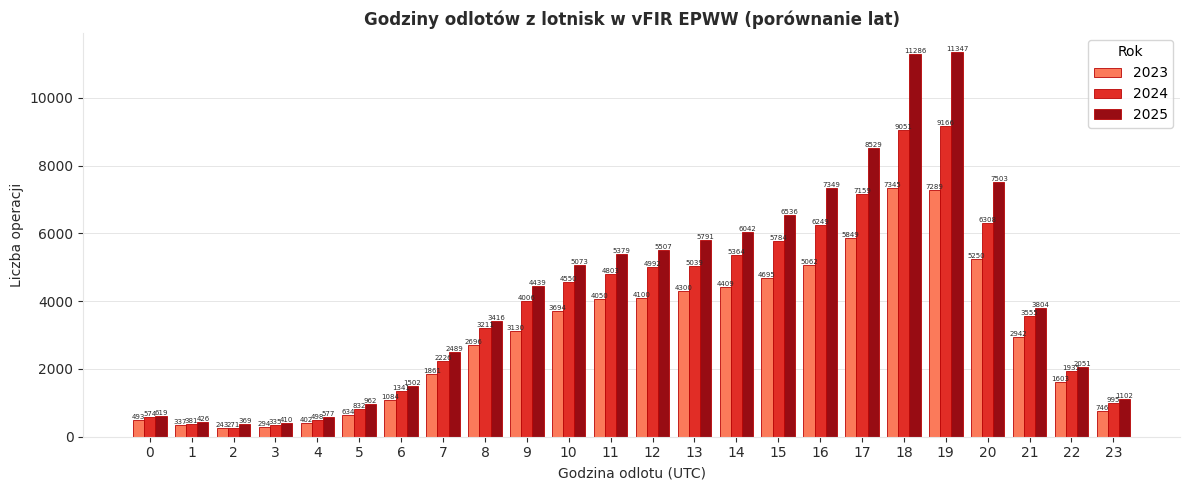

In [587]:
### Porównanie sumarycznej liczby odlotów w przeliczeniu na godziny odlotu (UTC)

ops_by_year = {
        year: get_all_ops_vfir(year, stats_by_year)
        for year in STATS_YEARS
    }
plot_ops_by_departure_hour_multi_year(ops_by_year)

W 2023 na lotniskach kontrolowanych: 75881 operacji (67226 unikalnych lotów) wykonanych przez 9191 pilotów.
Średnia liczba operacji dziennie:
    -> EPWA: 70.87
    -> EPMO: 10.10
    -> EPGD: 31.10
    -> EPKK: 46.47
    -> EPKT: 16.05
    -> EPPO: 7.49
    -> EPWR: 9.58
    -> EPLL: 2.46
    -> EPRA: 2.26
    -> EPBY: 2.57
    -> EPRZ: 5.13
    -> EPZG: 1.95
    -> EPSY: 2.46
    -> EPLB: 2.39
    -> EPSC: 2.88
--------------------------------------------------
W 2024 na lotniskach kontrolowanych: 92665 operacji (82788 unikalnych lotów) wykonanych przez 11196 pilotów.
Średnia liczba operacji dziennie:
    -> EPWA: 94.89
    -> EPMO: 9.22
    -> EPGD: 39.97
    -> EPKK: 52.77
    -> EPKT: 20.74
    -> EPPO: 7.49
    -> EPWR: 11.47
    -> EPLL: 2.63
    -> EPRA: 1.58
    -> EPBY: 2.73
    -> EPRZ: 5.53
    -> EPZG: 1.92
    -> EPSY: 2.15
    -> EPLB: 2.60
    -> EPSC: 2.81
--------------------------------------------------
W 2025 na lotniskach kontrolowanych: 107223 operacji (97111 uni

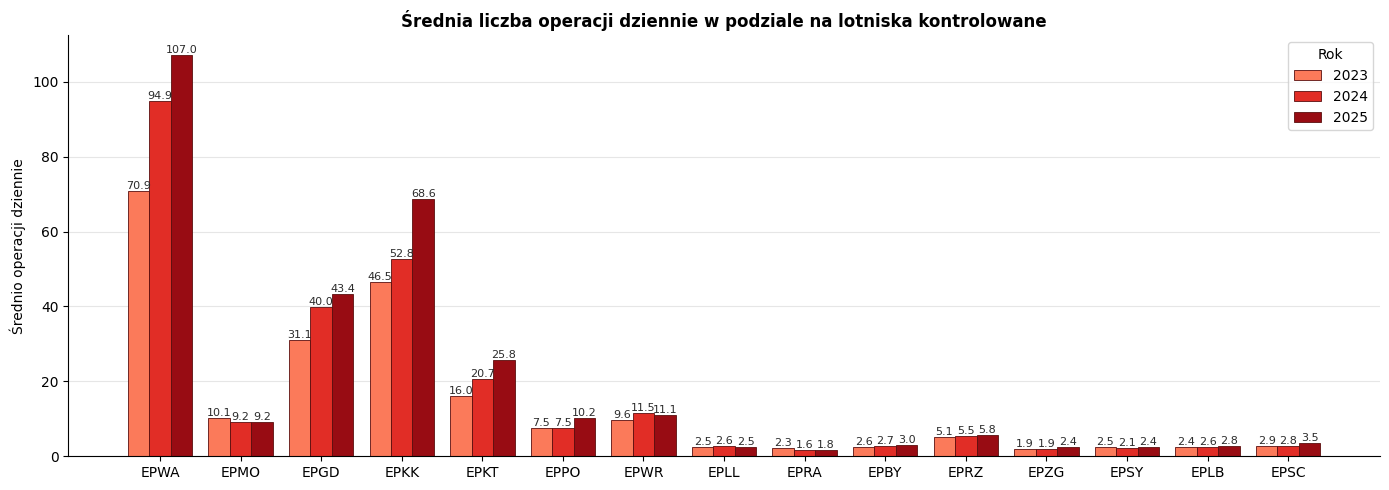



------> Dla porównania operacje w koszyku porównawczym (EDDM, EDDL, LKPR, EFHK, LOWW, ENBR, EETN) <------


W 2023 na lotniskach kontrolowanych: 249825 operacji (238234 unikalnych lotów) wykonanych przez 24084 pilotów.
Średnia liczba operacji dziennie:
    -> EDDM: 232.47
    -> EDDL: 97.15
    -> LKPR: 66.33
    -> EFHK: 72.24
    -> LOWW: 144.24
    -> ENBR: 58.62
    -> EETN: 13.41
--------------------------------------------------
W 2024 na lotniskach kontrolowanych: 297223 operacji (283797 unikalnych lotów) wykonanych przez 28455 pilotów.
Średnia liczba operacji dziennie:
    -> EDDM: 291.07
    -> EDDL: 124.53
    -> LKPR: 69.50
    -> EFHK: 86.69
    -> LOWW: 160.74
    -> ENBR: 62.64
    -> EETN: 16.91
--------------------------------------------------
W 2025 na lotniskach kontrolowanych: 328199 operacji (314598 unikalnych lotów) wykonanych przez 29836 pilotów.
Średnia liczba operacji dziennie:
    -> EDDM: 316.28
    -> EDDL: 148.84
    -> LKPR: 80.54
    -> EFHK: 102.73
   

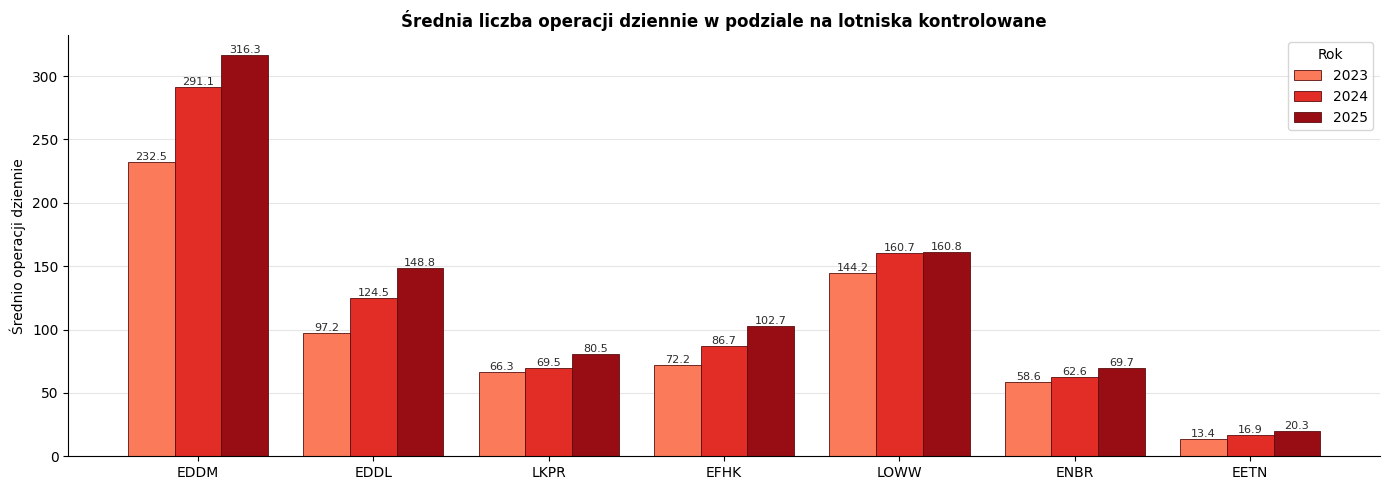

In [588]:
### Porównanie średniej liczby operacji dziennie na lotniskach kontrolowanych

avg_ops_by_year = {
    year: get_avg_ops(year, stats_by_year, aerodromes)
    for year in STATS_YEARS
}
plot_avg_ops_by_aerodrome(avg_ops_by_year, aerodromes)

print('''

------> Dla porównania operacje w koszyku porównawczym (EDDM, EDDL, LKPR, EFHK, LOWW, ENBR, EETN) <------

''')

comparative_avg_ops_by_year = {
    year: get_avg_ops(year, comparative_stats_by_year, aerodromes_comparative_basket)
    for year in STATS_YEARS
}
plot_avg_ops_by_aerodrome(comparative_avg_ops_by_year, aerodromes_comparative_basket)





------> Operacje w vFIR EPWW w rozbiciu na dni tygodnia <------


Zmiana rdr 2024/2023: +16784 operacji (22.11%)

Zmiany 2024/2023 dla poszczególnych dni tygodnia:
     -> poniedziałek: 27.96%
     -> wtorek: 21.62%
     -> środa: 21.01%
     -> czwartek: 20.12%
     -> piątek: 17.97%
     -> sobota: 24.69%
     -> niedziela: 21.30%

Zmiana rdr 2025/2024: +14558 operacji (15.71%)

Zmiany 2025/2024 dla poszczególnych dni tygodnia:
     -> poniedziałek: 12.80%
     -> wtorek: 19.41%
     -> środa: 15.81%
     -> czwartek: 10.93%
     -> piątek: 11.93%
     -> sobota: 8.05%
     -> niedziela: 29.06%



------> Operacje na poszczególnych polskich lotniskach kontrolowanych w rozbiciu na dni tygodnia <------


1. EPWA

Zmiana rdr 2024/2023: +8863 operacji (34.26%)

Zmiany 2024/2023 dla poszczególnych dni tygodnia:
     -> poniedziałek: 44.04%
     -> wtorek: 33.80%
     -> środa: 36.74%
     -> czwartek: 36.44%
     -> piątek: 23.84%
     -> sobota: 33.50%
     -> niedziela: 34.28%

Zmiana

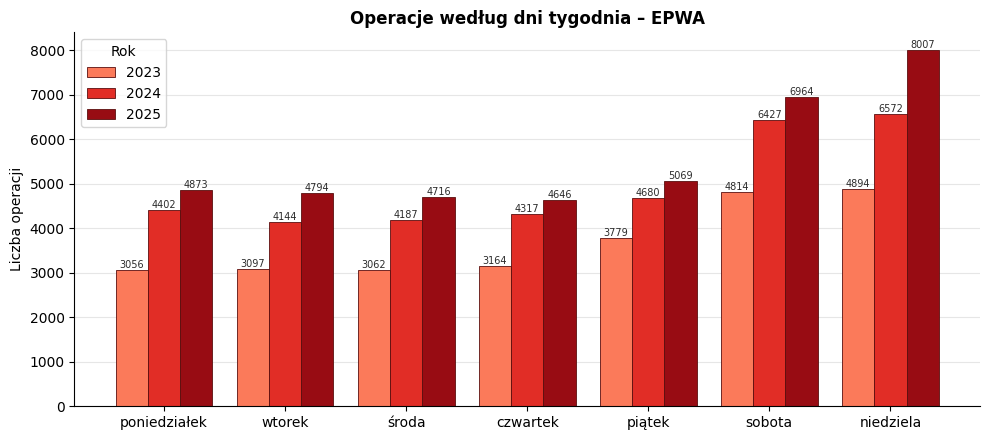

2. EPMO

Zmiana rdr 2024/2023: -313 operacji (-8.50%)

Zmiany 2024/2023 dla poszczególnych dni tygodnia:
     -> poniedziałek: -1.95%
     -> wtorek: -12.08%
     -> środa: -4.47%
     -> czwartek: -6.18%
     -> piątek: -7.48%
     -> sobota: -10.94%
     -> niedziela: -14.29%

Zmiana rdr 2025/2024: -42 operacji (-1.25%)

Zmiany 2025/2024 dla poszczególnych dni tygodnia:
     -> poniedziałek: -1.00%
     -> wtorek: -3.11%
     -> środa: 6.54%
     -> czwartek: -16.89%
     -> piątek: -9.94%
     -> sobota: -1.41%
     -> niedziela: 14.65%



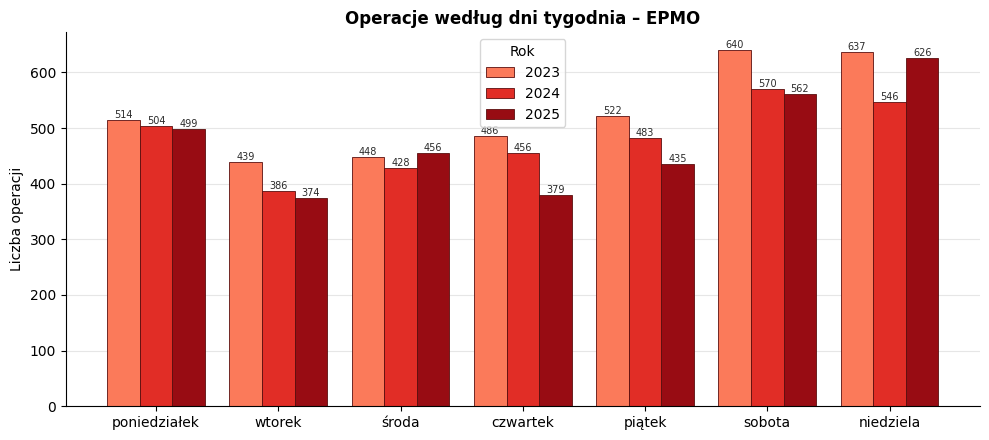

3. EPGD

Zmiana rdr 2024/2023: +3278 operacji (28.87%)

Zmiany 2024/2023 dla poszczególnych dni tygodnia:
     -> poniedziałek: 28.56%
     -> wtorek: 24.61%
     -> środa: 24.55%
     -> czwartek: 24.46%
     -> piątek: 36.14%
     -> sobota: 28.57%
     -> niedziela: 33.33%

Zmiana rdr 2025/2024: +1212 operacji (8.28%)

Zmiany 2025/2024 dla poszczególnych dni tygodnia:
     -> poniedziałek: 9.47%
     -> wtorek: 12.73%
     -> środa: 4.70%
     -> czwartek: 2.66%
     -> piątek: -8.40%
     -> sobota: 2.46%
     -> niedziela: 31.34%



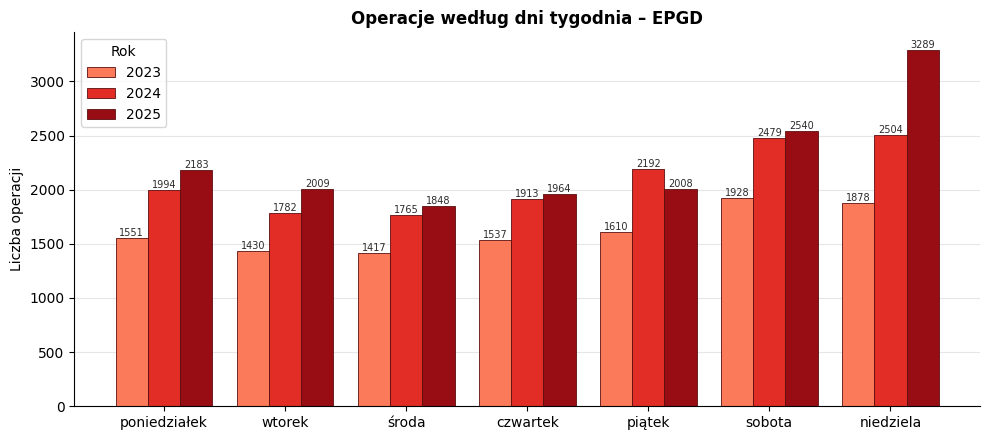

4. EPKK

Zmiana rdr 2024/2023: +2350 operacji (13.85%)

Zmiany 2024/2023 dla poszczególnych dni tygodnia:
     -> poniedziałek: 19.31%
     -> wtorek: 17.09%
     -> środa: 13.90%
     -> czwartek: 7.61%
     -> piątek: 10.02%
     -> sobota: 18.39%
     -> niedziela: 10.87%

Zmiana rdr 2025/2024: +5728 operacji (29.66%)

Zmiany 2025/2024 dla poszczególnych dni tygodnia:
     -> poniedziałek: 23.59%
     -> wtorek: 36.57%
     -> środa: 28.66%
     -> czwartek: 36.19%
     -> piątek: 30.87%
     -> sobota: 17.92%
     -> niedziela: 36.11%



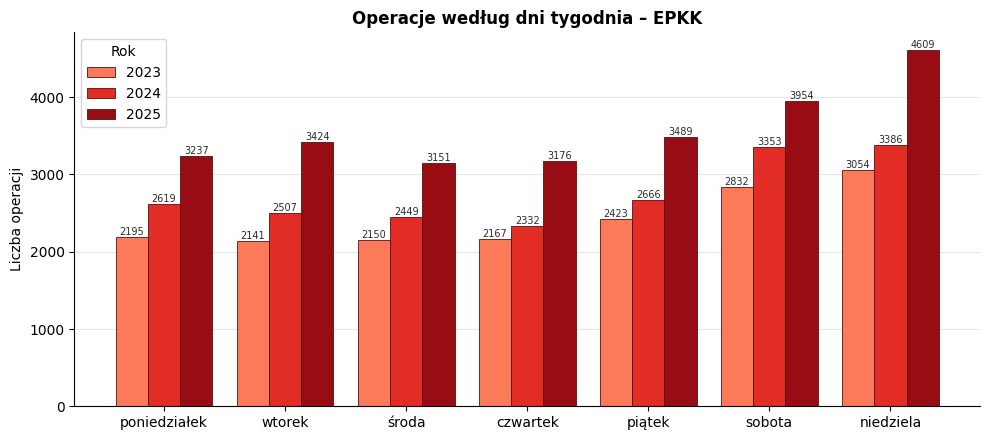

5. EPKT

Zmiana rdr 2024/2023: +1734 operacji (29.60%)

Zmiany 2024/2023 dla poszczególnych dni tygodnia:
     -> poniedziałek: 39.28%
     -> wtorek: 20.86%
     -> środa: 15.43%
     -> czwartek: 19.95%
     -> piątek: 21.09%
     -> sobota: 57.63%
     -> niedziela: 28.22%

Zmiana rdr 2025/2024: +1810 operacji (23.84%)

Zmiany 2025/2024 dla poszczególnych dni tygodnia:
     -> poniedziałek: 14.39%
     -> wtorek: 37.74%
     -> środa: 27.95%
     -> czwartek: 24.64%
     -> piątek: 30.61%
     -> sobota: 0.80%
     -> niedziela: 39.32%



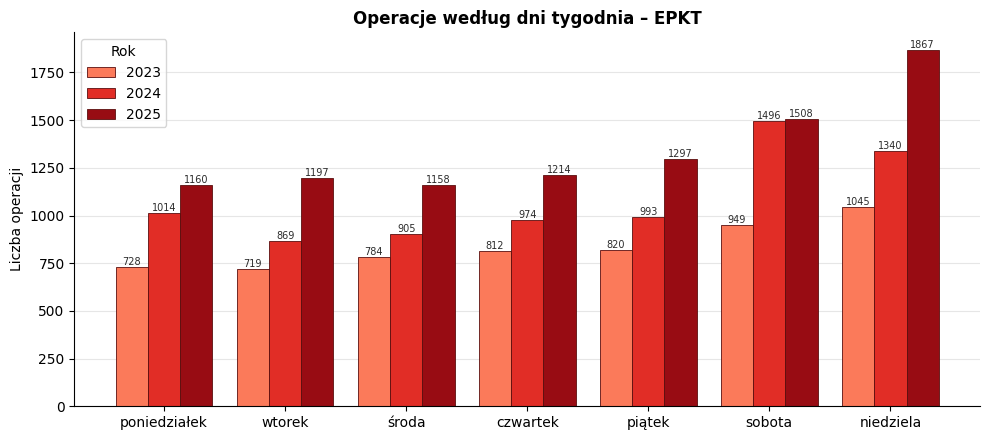

6. EPPO

Zmiana rdr 2024/2023: +9 operacji (0.33%)

Zmiany 2024/2023 dla poszczególnych dni tygodnia:
     -> poniedziałek: 6.54%
     -> wtorek: 5.55%
     -> środa: 13.54%
     -> czwartek: -5.11%
     -> piątek: 6.46%
     -> sobota: 0.81%
     -> niedziela: -14.09%

Zmiana rdr 2025/2024: +989 operacji (36.25%)

Zmiany 2025/2024 dla poszczególnych dni tygodnia:
     -> poniedziałek: 34.07%
     -> wtorek: 21.63%
     -> środa: 17.61%
     -> czwartek: 6.79%
     -> piątek: 53.17%
     -> sobota: 28.08%
     -> niedziela: 79.66%



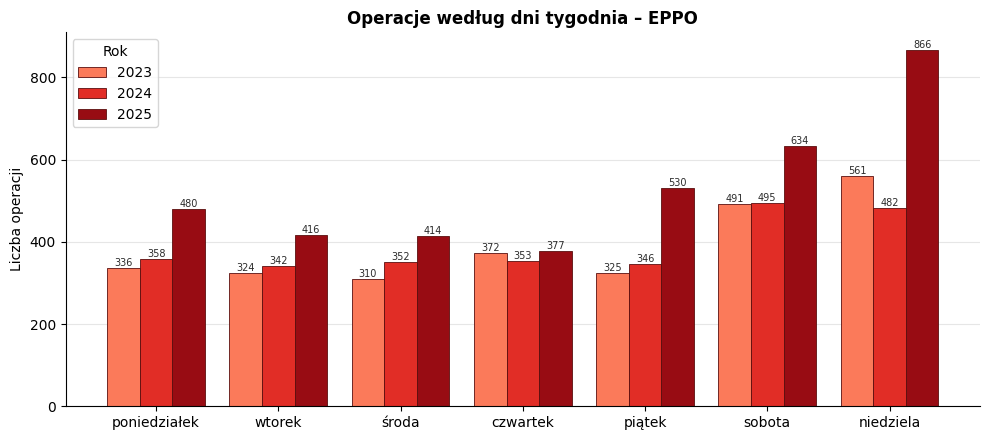

7. EPWR

Zmiana rdr 2024/2023: +704 operacji (20.14%)

Zmiany 2024/2023 dla poszczególnych dni tygodnia:
     -> poniedziałek: 17.89%
     -> wtorek: 11.42%
     -> środa: 8.20%
     -> czwartek: 37.07%
     -> piątek: 21.85%
     -> sobota: 22.09%
     -> niedziela: 22.20%

Zmiana rdr 2025/2024: -223 operacji (-5.32%)

Zmiany 2025/2024 dla poszczególnych dni tygodnia:
     -> poniedziałek: -2.86%
     -> wtorek: -2.39%
     -> środa: 15.15%
     -> czwartek: -25.05%
     -> piątek: -7.43%
     -> sobota: -20.28%
     -> niedziela: 10.10%



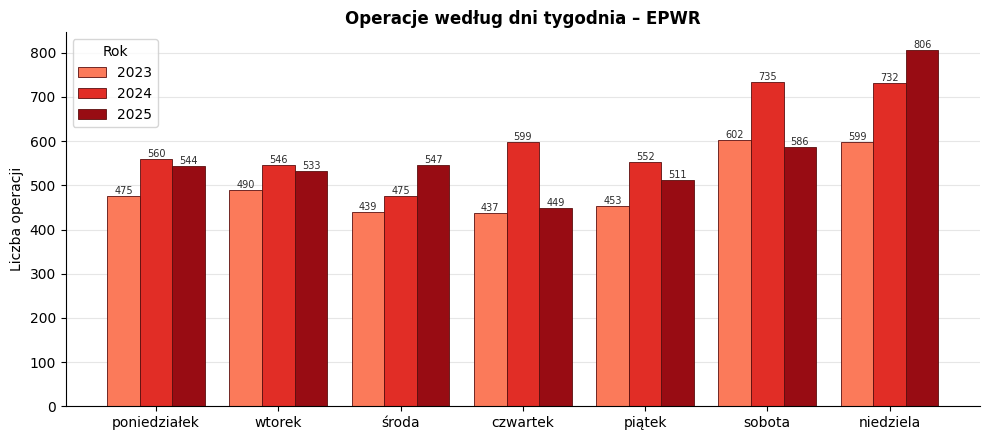

8. EPLL

Zmiana rdr 2024/2023: +78 operacji (12.62%)

Zmiany 2024/2023 dla poszczególnych dni tygodnia:
     -> poniedziałek: 8.33%
     -> wtorek: 6.57%
     -> środa: 7.81%
     -> czwartek: 26.58%
     -> piątek: 32.09%
     -> sobota: 13.72%
     -> niedziela: 0.00%

Zmiana rdr 2025/2024: +6 operacji (0.86%)

Zmiany 2025/2024 dla poszczególnych dni tygodnia:
     -> poniedziałek: -3.30%
     -> wtorek: -2.47%
     -> środa: 36.23%
     -> czwartek: -1.01%
     -> piątek: -8.42%
     -> sobota: -5.18%
     -> niedziela: 1.51%



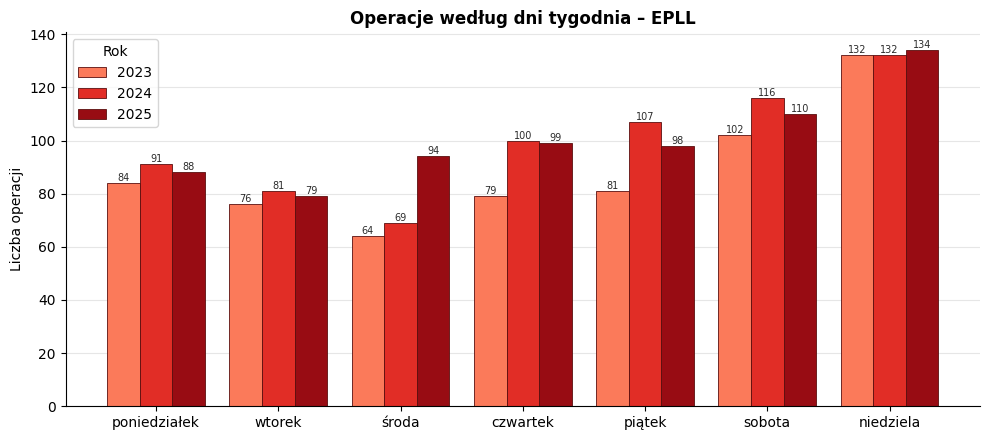

9. EPRA

Zmiana rdr 2024/2023: -123 operacji (-39.81%)

Zmiany 2024/2023 dla poszczególnych dni tygodnia:
     -> poniedziałek: -50.00%
     -> wtorek: -8.58%
     -> środa: -39.48%
     -> czwartek: -52.95%
     -> piątek: -55.72%
     -> sobota: -57.15%
     -> niedziela: -7.85%

Zmiana rdr 2025/2024: +38 operacji (20.43%)

Zmiany 2025/2024 dla poszczególnych dni tygodnia:
     -> poniedziałek: 31.25%
     -> wtorek: -21.88%
     -> środa: 0.00%
     -> czwartek: 50.00%
     -> piątek: -16.13%
     -> sobota: 138.09%
     -> niedziela: 17.02%



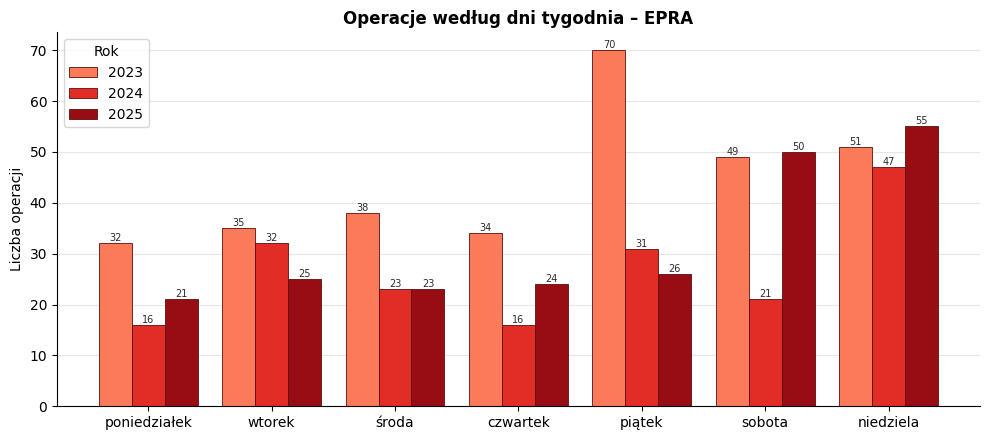

10. EPBY

Zmiana rdr 2024/2023: +38 operacji (4.95%)

Zmiany 2024/2023 dla poszczególnych dni tygodnia:
     -> poniedziałek: -3.89%
     -> wtorek: 46.24%
     -> środa: 23.17%
     -> czwartek: 17.04%
     -> piątek: -21.19%
     -> sobota: -4.81%
     -> niedziela: 1.16%

Zmiana rdr 2025/2024: +5 operacji (0.62%)

Zmiany 2025/2024 dla poszczególnych dni tygodnia:
     -> poniedziałek: -19.20%
     -> wtorek: -22.23%
     -> środa: -14.86%
     -> czwartek: -12.63%
     -> piątek: 22.58%
     -> sobota: -5.89%
     -> niedziela: 36.99%



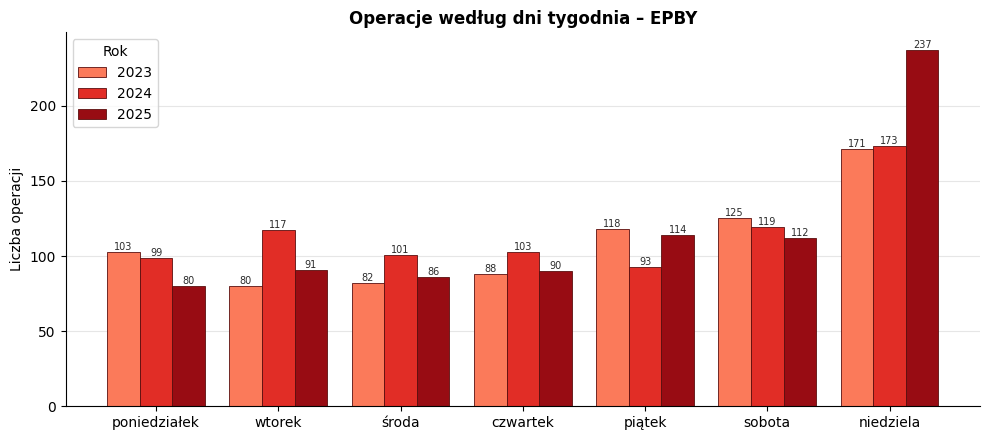

11. EPRZ

Zmiana rdr 2024/2023: +151 operacji (8.31%)

Zmiany 2024/2023 dla poszczególnych dni tygodnia:
     -> poniedziałek: 31.11%
     -> wtorek: 0.82%
     -> środa: 20.87%
     -> czwartek: -0.80%
     -> piątek: 8.17%
     -> sobota: -6.57%
     -> niedziela: 12.06%

Zmiana rdr 2025/2024: +111 operacji (5.64%)

Zmiany 2025/2024 dla poszczególnych dni tygodnia:
     -> poniedziałek: -6.78%
     -> wtorek: 7.75%
     -> środa: -1.61%
     -> czwartek: 6.02%
     -> piątek: -6.84%
     -> sobota: 11.37%
     -> niedziela: 24.36%



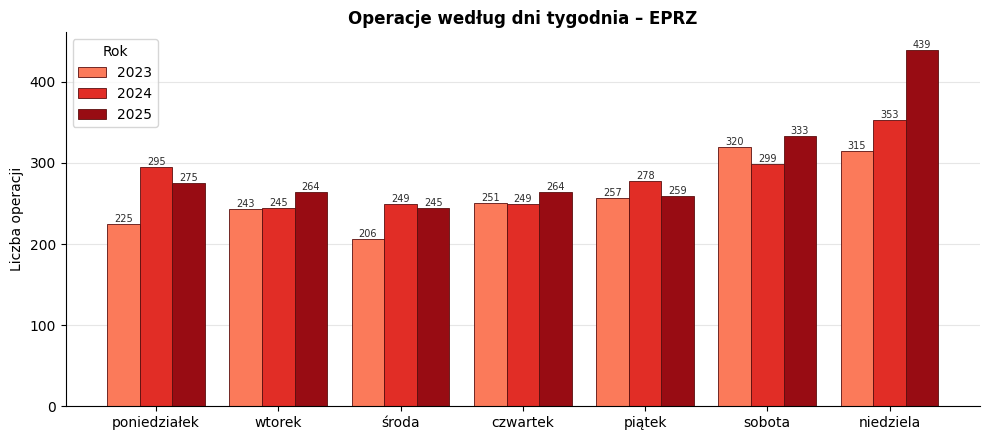

12. EPZG

Zmiana rdr 2024/2023: +38 operacji (11.48%)

Zmiany 2024/2023 dla poszczególnych dni tygodnia:
     -> poniedziałek: 41.93%
     -> wtorek: 56.25%
     -> środa: 17.39%
     -> czwartek: 0.00%
     -> piątek: -24.14%
     -> sobota: -5.67%
     -> niedziela: 25.39%

Zmiana rdr 2025/2024: +77 operacji (20.86%)

Zmiany 2025/2024 dla poszczególnych dni tygodnia:
     -> poniedziałek: 47.72%
     -> wtorek: -6.01%
     -> środa: -37.04%
     -> czwartek: -27.09%
     -> piątek: 6.81%
     -> sobota: 54.00%
     -> niedziela: 78.48%



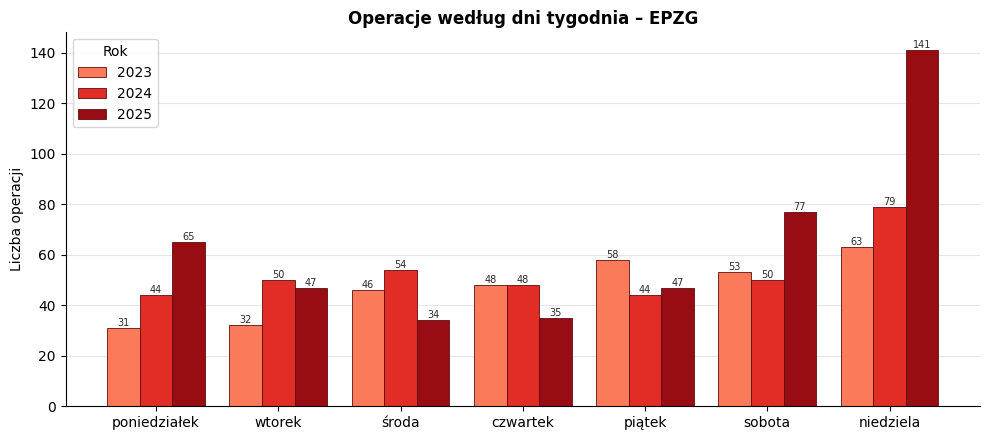

13. EPSY

Zmiana rdr 2024/2023: -43 operacji (-7.08%)

Zmiany 2024/2023 dla poszczególnych dni tygodnia:
     -> poniedziałek: 7.04%
     -> wtorek: -1.29%
     -> środa: 8.92%
     -> czwartek: -19.61%
     -> piątek: 5.33%
     -> sobota: -10.72%
     -> niedziela: -21.06%

Zmiana rdr 2025/2024: +66 operacji (11.68%)

Zmiany 2025/2024 dla poszczególnych dni tygodnia:
     -> poniedziałek: 50.00%
     -> wtorek: 6.49%
     -> środa: 22.95%
     -> czwartek: -23.18%
     -> piątek: 13.92%
     -> sobota: 10.00%
     -> niedziela: 7.77%



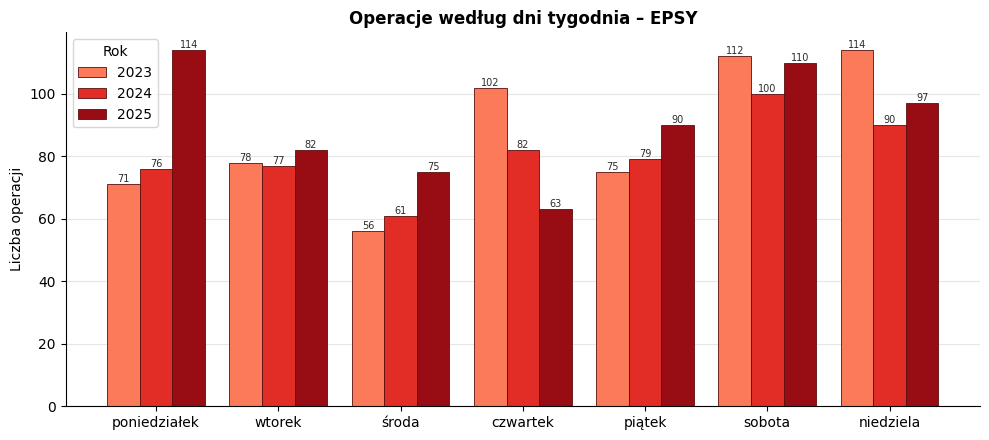

14. EPLB

Zmiana rdr 2024/2023: +99 operacji (15.37%)

Zmiany 2024/2023 dla poszczególnych dni tygodnia:
     -> poniedziałek: 28.88%
     -> wtorek: 1.33%
     -> środa: -16.53%
     -> czwartek: 65.78%
     -> piątek: -4.91%
     -> sobota: 30.33%
     -> niedziela: 19.58%

Zmiana rdr 2025/2024: +77 operacji (10.36%)

Zmiany 2025/2024 dla poszczególnych dni tygodnia:
     -> poniedziałek: -5.18%
     -> wtorek: 5.26%
     -> środa: 8.33%
     -> czwartek: -4.77%
     -> piątek: 24.74%
     -> sobota: 19.82%
     -> niedziela: 25.86%



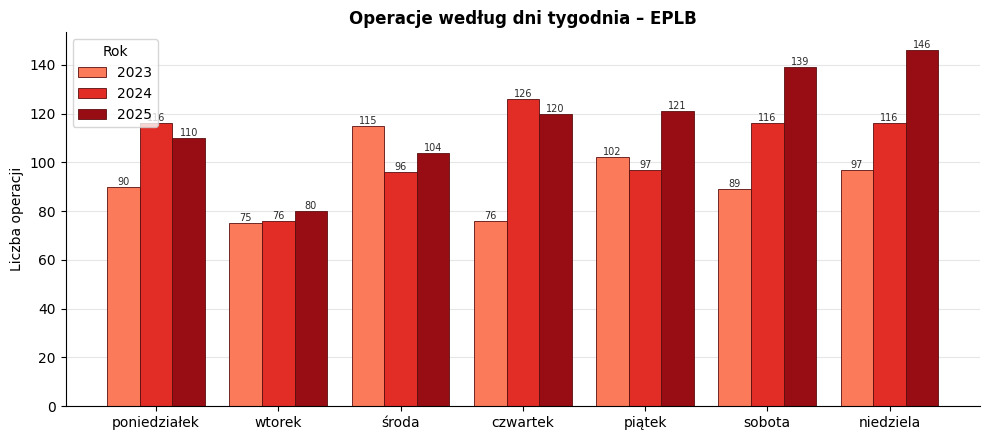

15. EPSC

Zmiana rdr 2024/2023: -79 operacji (-9.29%)

Zmiany 2024/2023 dla poszczególnych dni tygodnia:
     -> poniedziałek: -8.55%
     -> wtorek: 29.34%
     -> środa: -27.65%
     -> czwartek: -37.01%
     -> piątek: -6.80%
     -> sobota: 0.71%
     -> niedziela: -6.05%

Zmiana rdr 2025/2024: +364 operacji (47.15%)

Zmiany 2025/2024 dla poszczególnych dni tygodnia:
     -> poniedziałek: 30.84%
     -> wtorek: 39.49%
     -> środa: 57.30%
     -> czwartek: 66.25%
     -> piątek: 69.79%
     -> sobota: 19.85%
     -> niedziela: 60.71%



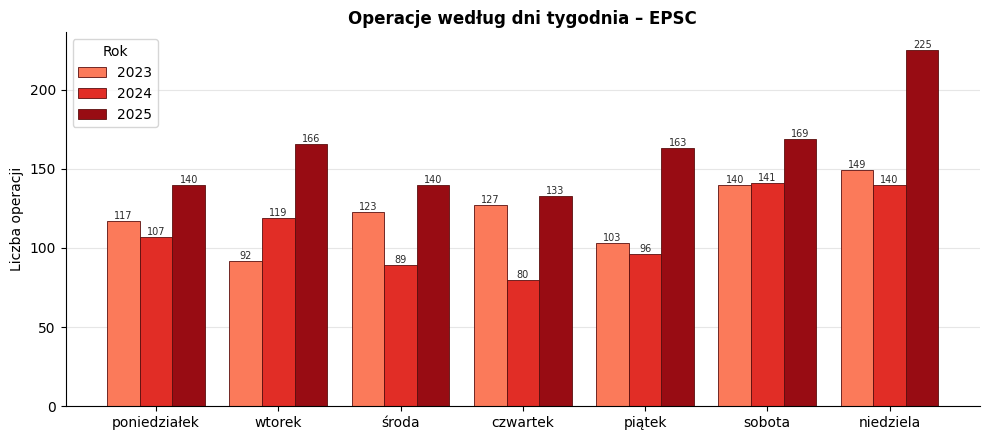



------> Dla porównania operacje w koszyku porównawczym (EDDM, EDDL, LKPR, EFHK, LOWW, ENBR, EETN) <------


1. EDDM

Zmiana rdr 2024/2023: +21683 operacji (25.55%)

Zmiany 2024/2023 dla poszczególnych dni tygodnia:
     -> poniedziałek: 27.88%
     -> wtorek: 32.76%
     -> środa: 21.19%
     -> czwartek: 35.71%
     -> piątek: 13.18%
     -> sobota: 26.42%
     -> niedziela: 26.58%

Zmiana rdr 2025/2024: +8910 operacji (8.36%)

Zmiany 2025/2024 dla poszczególnych dni tygodnia:
     -> poniedziałek: 10.38%
     -> wtorek: 9.61%
     -> środa: 12.55%
     -> czwartek: 9.22%
     -> piątek: 8.64%
     -> sobota: 6.12%
     -> niedziela: 3.29%



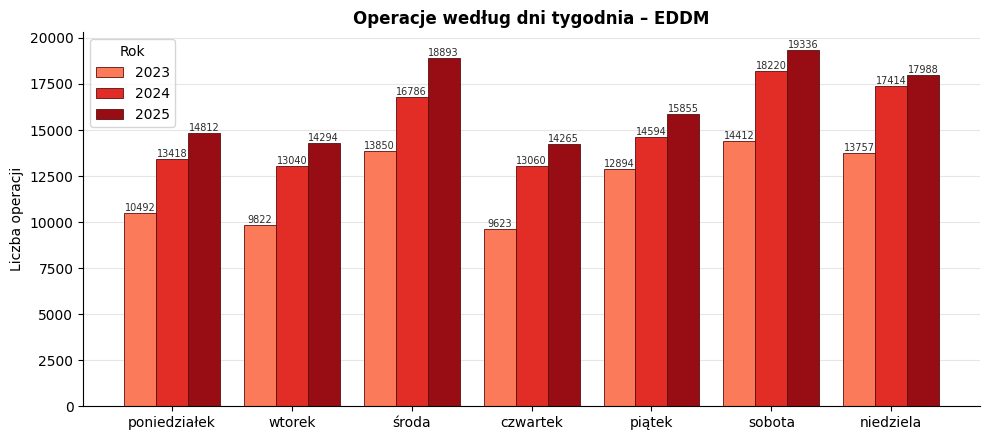

2. EDDL

Zmiana rdr 2024/2023: +10118 operacji (28.53%)

Zmiany 2024/2023 dla poszczególnych dni tygodnia:
     -> poniedziałek: 19.63%
     -> wtorek: 24.75%
     -> środa: 21.92%
     -> czwartek: 30.99%
     -> piątek: 26.59%
     -> sobota: 47.01%
     -> niedziela: 35.64%

Zmiana rdr 2025/2024: +8749 operacji (19.19%)

Zmiany 2025/2024 dla poszczególnych dni tygodnia:
     -> poniedziałek: 6.32%
     -> wtorek: 29.75%
     -> środa: 29.03%
     -> czwartek: 15.24%
     -> piątek: 30.84%
     -> sobota: 13.58%
     -> niedziela: 23.77%



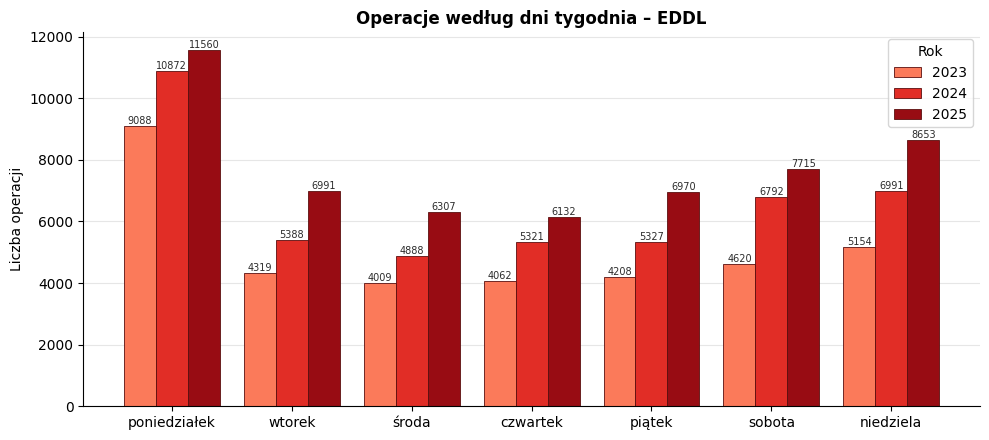

3. LKPR

Zmiana rdr 2024/2023: +1228 operacji (5.07%)

Zmiany 2024/2023 dla poszczególnych dni tygodnia:
     -> poniedziałek: 5.00%
     -> wtorek: -1.06%
     -> środa: 14.03%
     -> czwartek: 7.34%
     -> piątek: -0.43%
     -> sobota: 5.22%
     -> niedziela: 0.78%

Zmiana rdr 2025/2024: +3961 operacji (15.57%)

Zmiany 2025/2024 dla poszczególnych dni tygodnia:
     -> poniedziałek: 24.25%
     -> wtorek: 11.79%
     -> środa: 8.45%
     -> czwartek: 17.67%
     -> piątek: 25.41%
     -> sobota: 10.12%
     -> niedziela: 17.94%



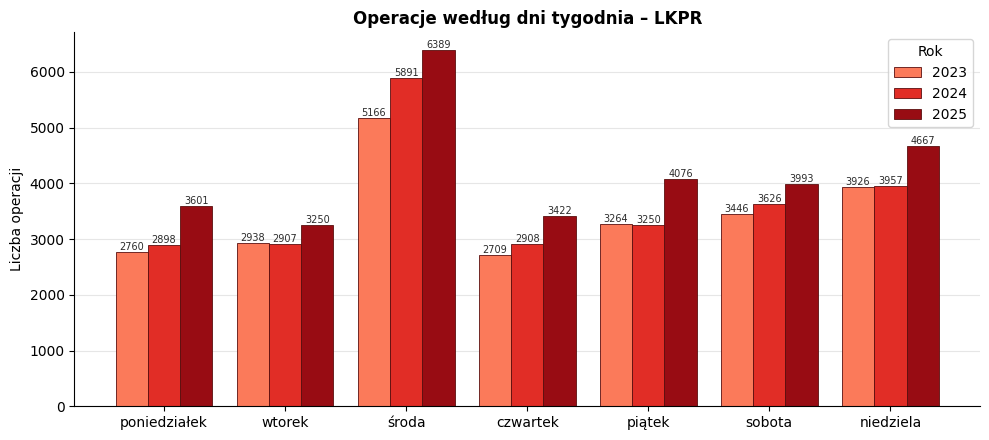

4. EFHK

Zmiana rdr 2024/2023: +5361 operacji (20.33%)

Zmiany 2024/2023 dla poszczególnych dni tygodnia:
     -> poniedziałek: 19.99%
     -> wtorek: 21.09%
     -> środa: 23.62%
     -> czwartek: 15.63%
     -> piątek: 22.04%
     -> sobota: 18.07%
     -> niedziela: 26.64%

Zmiana rdr 2025/2024: +5769 operacji (18.18%)

Zmiany 2025/2024 dla poszczególnych dni tygodnia:
     -> poniedziałek: 13.87%
     -> wtorek: 12.91%
     -> środa: 20.49%
     -> czwartek: 20.77%
     -> piątek: 22.47%
     -> sobota: 12.31%
     -> niedziela: 23.27%



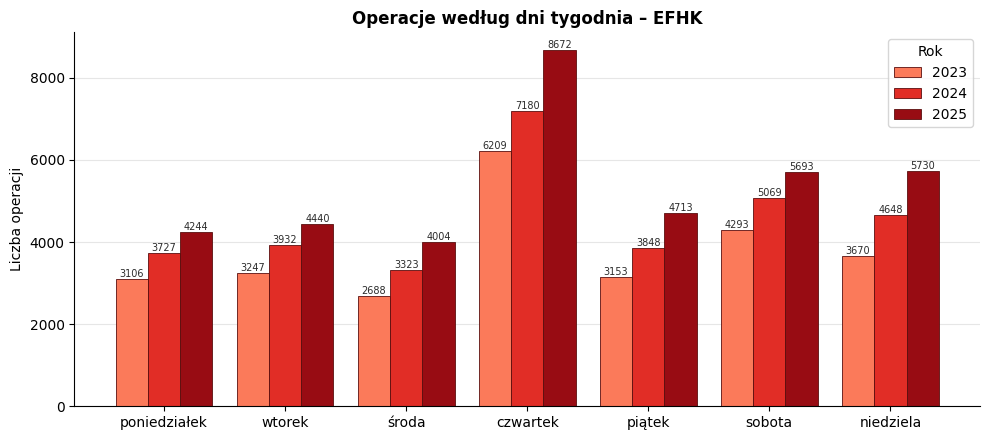

5. LOWW

Zmiana rdr 2024/2023: +6183 operacji (11.74%)

Zmiany 2024/2023 dla poszczególnych dni tygodnia:
     -> poniedziałek: 23.50%
     -> wtorek: 9.73%
     -> środa: 15.13%
     -> czwartek: 6.61%
     -> piątek: 8.61%
     -> sobota: 9.23%
     -> niedziela: 8.75%

Zmiana rdr 2025/2024: -123 operacji (-0.21%)

Zmiany 2025/2024 dla poszczególnych dni tygodnia:
     -> poniedziałek: -9.84%
     -> wtorek: 2.16%
     -> środa: 8.30%
     -> czwartek: 2.04%
     -> piątek: 0.51%
     -> sobota: -1.71%
     -> niedziela: -3.73%



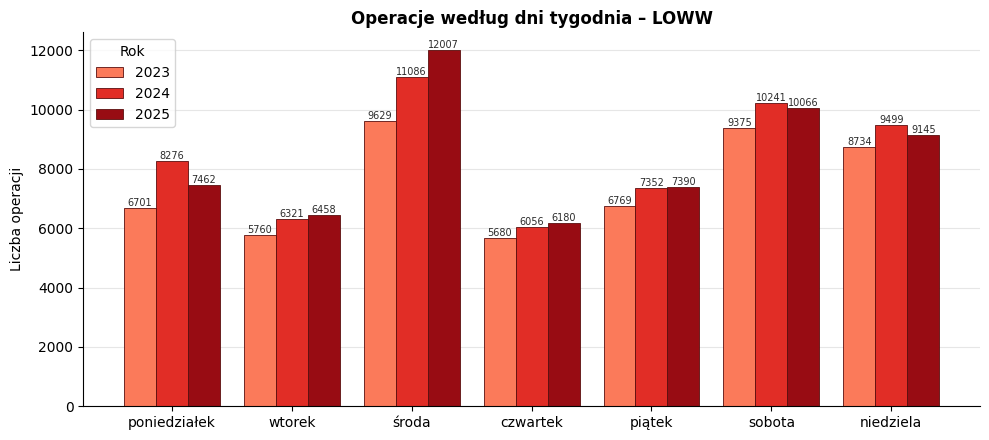

6. ENBR

Zmiana rdr 2024/2023: +1533 operacji (7.16%)

Zmiany 2024/2023 dla poszczególnych dni tygodnia:
     -> poniedziałek: -5.87%
     -> wtorek: 7.06%
     -> środa: 5.37%
     -> czwartek: 17.50%
     -> piątek: 18.89%
     -> sobota: 2.83%
     -> niedziela: 11.26%

Zmiana rdr 2025/2024: +2500 operacji (10.90%)

Zmiany 2025/2024 dla poszczególnych dni tygodnia:
     -> poniedziałek: 38.06%
     -> wtorek: 7.25%
     -> środa: 15.06%
     -> czwartek: -2.83%
     -> piątek: 1.11%
     -> sobota: 4.79%
     -> niedziela: 8.98%



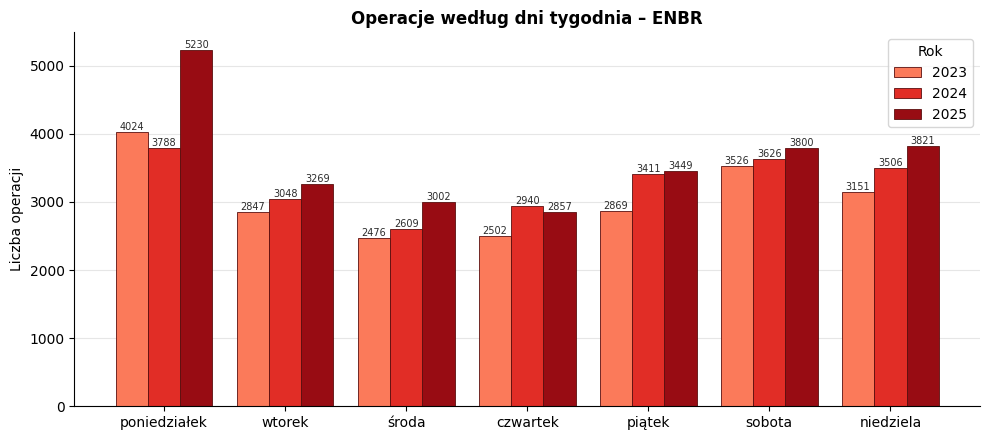

7. EETN

Zmiana rdr 2024/2023: +1292 operacji (26.38%)

Zmiany 2024/2023 dla poszczególnych dni tygodnia:
     -> poniedziałek: 19.56%
     -> wtorek: 10.04%
     -> środa: 13.41%
     -> czwartek: 15.84%
     -> piątek: 93.01%
     -> sobota: 18.34%
     -> niedziela: 20.19%

Zmiana rdr 2025/2024: +1210 operacji (19.55%)

Zmiany 2025/2024 dla poszczególnych dni tygodnia:
     -> poniedziałek: 15.07%
     -> wtorek: 80.17%
     -> środa: 12.84%
     -> czwartek: 33.80%
     -> piątek: 4.52%
     -> sobota: 9.71%
     -> niedziela: 2.28%



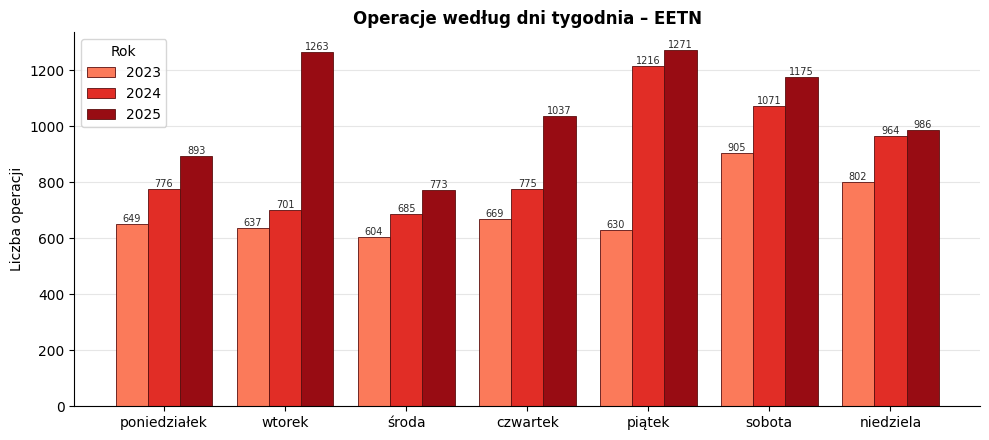

In [589]:
### Porównanie liczby operacji w poszczególne dni tygodnia

year_pairs = list(zip(STATS_YEARS, STATS_YEARS[1:]))

print('''

------> Operacje w vFIR EPWW w rozbiciu na dni tygodnia <------

''')

for year2, year1 in year_pairs:
    compare_two_years_vfir(year1, year2, stats_by_year, aerodromes)
    print()

print('''

------> Operacje na poszczególnych polskich lotniskach kontrolowanych w rozbiciu na dni tygodnia <------

''')

for idx, icao in enumerate(aerodromes):
    print(f'{idx+1}. {icao}\n')
    for year2, year1 in year_pairs:
        compare_two_years_aerodrome(icao, year1, year2, stats_by_year) # year2 to wcześniejszy!
        print()
    plot_weekday_ops_by_year(stats_by_year, STATS_YEARS, icao, aerodromes)

print('''

------> Dla porównania operacje w koszyku porównawczym (EDDM, EDDL, LKPR, EFHK, LOWW, ENBR, EETN) <------

''')

for idx, icao in enumerate(aerodromes_comparative_basket):
    print(f'{idx+1}. {icao}\n')
    for year2, year1 in year_pairs:
        compare_two_years_aerodrome(icao, year1, year2, comparative_stats_by_year) # year2 to wcześniejszy!
        print()
    plot_weekday_ops_by_year(comparative_stats_by_year, STATS_YEARS, icao, aerodromes_comparative_basket)

In [583]:
### Najczęstsze trasy w danym roku z poszczególnych lotnisk kontrolowanych

for year in STATS_YEARS:
    print(f'Najczęstsze trasy w {year}:')
    for icao in aerodromes:
        top3 = get_top_routes(stats_by_year, icao, year, 5)
        print(f'---> {icao}:')
        for idx, route in enumerate(top3):
            print(f'{idx+1}. {route[0]}: {route[1]} odlotów/y')  
    print(100 * '-')

Najczęstsze trasy w 2023:
---> EPWA:
1. EPWA-EPKK via EVINA M66 KUKAM: 609 odlotów/y
2. EPWA-EPGD via OLILA L621 RILAB T270 OSLOG: 535 odlotów/y
3. EPWA-EGLL via LOLSI T174 INDIG DCT SUBIX DCT PENEK DCT HLZ DCT AMSAN L980 RKN DCT NIGUG DCT ABNED L980 LOGAN: 230 odlotów/y
4. EPWA-EPKT via EVINA M66 KUKAM: 219 odlotów/y
5. EPWA-LKPR via SOXER N869 TOMTI DCT ASTEL DCT GOLOP: 218 odlotów/y
---> EPMO:
1. EPMO-EFHK via BAMSO Z182 ASLUX Z460 XESNA M857 SOKVA DCT KEMET Q11 INTOR: 117 odlotów/y
2. EPMO-LOWW via EVINA DCT NAVUR N744 TUSIN DCT MIKOV: 48 odlotów/y
3. EPMO-ENTO via OLILA L621 GRUDA N133 KARTI Y41 LARMA DCT NILEN L617 REPKU: 38 odlotów/y
4. EPMO-EFHK via BAMSO DCT ASLUX DCT XESNA DCT BULEP DCT BOKSU DCT VAKAL M857 SOKVA DCT KEMET Q11 INTOR: 34 odlotów/y
5. EPMO-EPSC via OLILA DCT ELTUB: 34 odlotów/y
---> EPGD:
1. EPGD-EPWA via IRLUN N133 GRUDA N191 SORIX: 407 odlotów/y
2. EPGD-EPKK via IRLUN N133 NEGUV M66 KUKAM: 398 odlotów/y
3. EPGD-EKCH via DEXIR Y100 MALOX L621 ROE M743 TIDVU: 1

In [572]:
### Najczęstsze AD poza vFIR EPWW (przyloty i odloty)

def get_top_non_epww(stats_by_year, icao: str, year: int, top_n: int = 5):
    departures = defaultdict(int)
    destinations = defaultdict(int)
    for op in stats_by_year[year][icao]:
        if op['departure'] == icao: # odlot z lotniska w vFIR, ale destination poza vFIR EPWW
            if op['destination'] not in aerodromes:
                destinations[op['destination']] += 1
        else:                       # przylot, a origin poza vFIR EPWW
            if op['departure'] not in aerodromes:
                departures[op['departure']] += 1
    
    c1, c2 = Counter(departures), Counter(destinations)
    return c1.most_common(top_n), c2.most_common(top_n)

for year in STATS_YEARS:
    print(f'Najczęstsze połączenia z lotniskami spoza vFIR EPWW w {year}:')
    for icao in aerodromes:
        print(f'---> {icao}:')
        departures, destinations = get_top_non_epww(stats_by_year, icao, year, 5)
        print('A. Odloty do:')
        for idx, data in enumerate(destinations):
            non_epww_icao, flights = data
            print(f'{idx+1}. {non_epww_icao} ({flights} lotów)')  
        print('B. Przyloty z:')
        for idx, data in enumerate(departures):
            non_epww_icao, flights = data
            print(f'{idx+1}. {non_epww_icao} ({flights} lotów)')  
    print(100 * '-')

Najczęstsze połączenia z lotniskami spoza vFIR EPWW w 2023:
---> EPWA:
A. Odloty do:
1. EDDF (464 lotów)
2. EKCH (437 lotów)
3. EGLL (432 lotów)
4. LKPR (401 lotów)
5. LOWW (391 lotów)
B. Przyloty z:
1. LOWW (468 lotów)
2. EDDF (384 lotów)
3. EKCH (376 lotów)
4. LKPR (362 lotów)
5. LHBP (339 lotów)
---> EPMO:
A. Odloty do:
1. EFHK (184 lotów)
2. LOWW (141 lotów)
3. EGSS (105 lotów)
4. EVRA (90 lotów)
5. ENTO (80 lotów)
B. Przyloty z:
1. ENTO (193 lotów)
2. LOWW (110 lotów)
3. EGSS (92 lotów)
4. LHBP (73 lotów)
5. EVRA (64 lotów)
---> EPGD:
A. Odloty do:
1. EKCH (378 lotów)
2. ESSA (202 lotów)
3. ENGM (182 lotów)
4. EDDH (172 lotów)
5. ESGG (170 lotów)
B. Przyloty z:
1. EKCH (344 lotów)
2. ENGM (160 lotów)
3. EDDH (155 lotów)
4. ESGG (155 lotów)
5. ESSA (130 lotów)
---> EPKK:
A. Odloty do:
1. LOWW (394 lotów)
2. EDDM (260 lotów)
3. LKPR (210 lotów)
4. EKCH (209 lotów)
5. EDDB (199 lotów)
B. Przyloty z:
1. LOWW (367 lotów)
2. EDDM (232 lotów)
3. EDDB (176 lotów)
4. EDDF (176 lotów)
5. EG

Loty w 2023 zaczynające się lub kończące w vFIR EPWW:

--> Unikalnych pilotów: 9191

--> Średnia liczba lotów przypadających na jednego pilota: 7.31


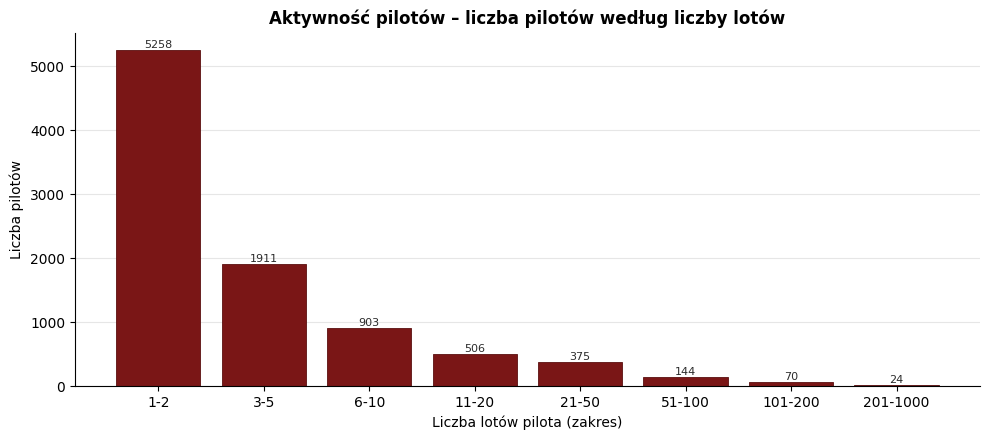

Loty w 2024 zaczynające się lub kończące w vFIR EPWW:

--> Unikalnych pilotów: 11196

--> Średnia liczba lotów przypadających na jednego pilota: 7.39


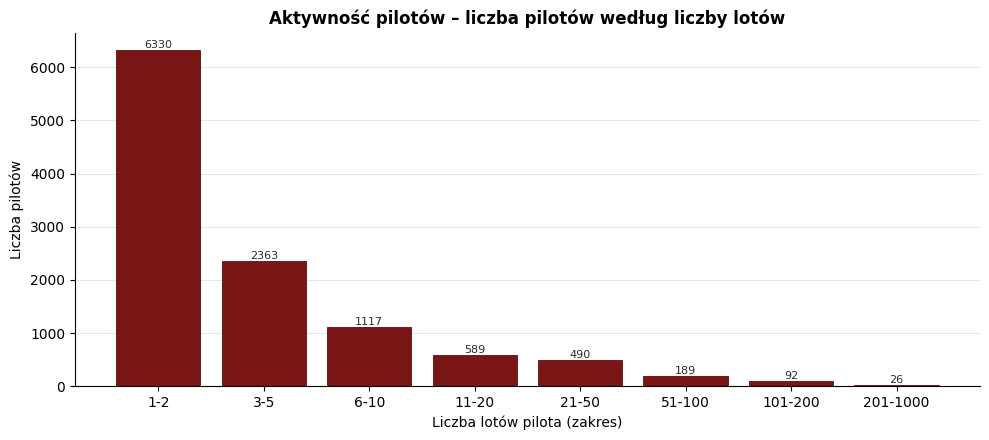

Loty w 2025 zaczynające się lub kończące w vFIR EPWW:

--> Unikalnych pilotów: 12496

--> Średnia liczba lotów przypadających na jednego pilota: 7.77


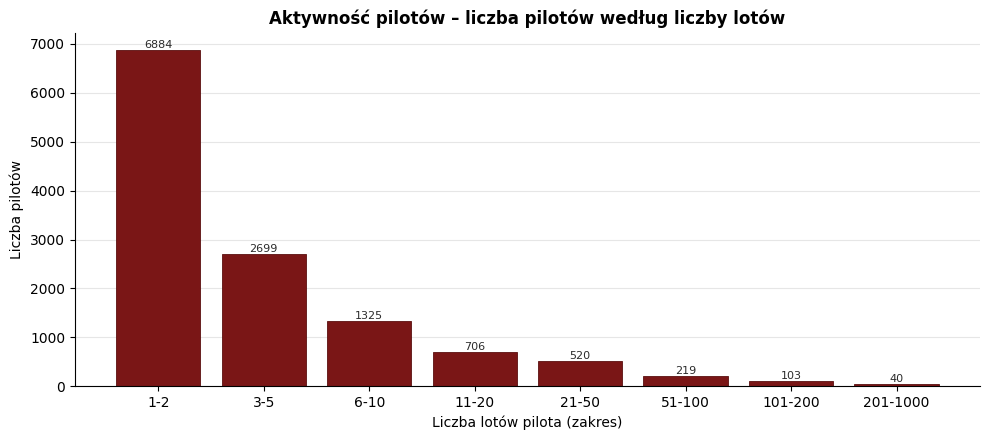

In [591]:
### Statystyki dotyczące pilotów

for year in STATS_YEARS:
    print(f'Loty w {year} zaczynające się lub kończące w vFIR EPWW:')
    pilot_flights = defaultdict(int)
    pilot_event_participation = defaultdict(int)
    visited_flights = set()
    for op in get_all_ops_vfir(year, stats_by_year):
        if op['id'] not in visited_flights:
            visited_flights.add(op['id'])
            pilot_flights[op['vatsimid']] += 1
    
    c = Counter(pilot_flights)

    print(f'\n--> Unikalnych pilotów: {len(c)}')
    
    print(f'\n--> Średnia liczba lotów przypadających na jednego pilota: {sum(c.values())/len(c):.2f}')
    plot_pilot_activity_buckets(bucket_counts = bucket_pilots(c, BINS))
    


In [590]:
# POMYSŁY
# statystyki w dni eventowe dla całego vFIR z wskazaniem lotnisk event/non-event
# ile lotów w EPWW wykonał przeciętny pilot rocznie vs. ile lotów wykonał w EPWW przeciętny pilot uczestniczący w evencie

''' 
e.g. stats_by_year = {2025: 'EPWA': [list_of_ops]}

OP SCHEMA
{
    "id": 0,
    "vatsimid": "string",
    "callsign": "string",
    "departure": "string",
    "destination": "string",
    "aircraft": "string",
    "altitude": "string",
    "route": "string",
    "departed": "2025-12-30T22:10:43.793Z",
    "arrived": "2025-12-30T22:10:43.793Z",
    "loggedOn": "2025-12-30T22:10:43.793Z"
  }
  '''


' \ne.g. stats_by_year = {2025: \'EPWA\': [list_of_ops]}\n\nOP SCHEMA\n{\n    "id": 0,\n    "vatsimid": "string",\n    "callsign": "string",\n    "departure": "string",\n    "destination": "string",\n    "aircraft": "string",\n    "altitude": "string",\n    "route": "string",\n    "departed": "2025-12-30T22:10:43.793Z",\n    "arrived": "2025-12-30T22:10:43.793Z",\n    "loggedOn": "2025-12-30T22:10:43.793Z"\n  }\n  '